In [117]:
from scipy.signal import find_peaks

In [2]:
def set_size(width_pt, fraction=1, subplots=(1, 1)):
    """Set figure dimensions to sit nicely in our document.

    Parameters
    ----------
    width_pt: float
            Document width in points
    fraction: float, optional
            Fraction of the width which you wish the figure to occupy
    subplots: array-like, optional
            The number of rows and columns of subplots.
    Returns
    -------
    fig_dim: tuple
            Dimensions of figure in inches
    """
    # Width of figure (in pts)
    fig_width_pt = width_pt * fraction
    # Convert from pt to inches
    inches_per_pt = 1 / 72.27

    # Golden ratio to set aesthetic figure height
    golden_ratio = (5**.5 - 1) / 2

    # Figure width in inches
    fig_width_in = fig_width_pt * inches_per_pt
    # Figure height in inches
    fig_height_in = fig_width_in * golden_ratio * (subplots[0] / subplots[1])

    return (fig_width_in, fig_height_in)

def set_size_square(width_pt, fraction=1, subplots=(1, 1)):
    """Set figure dimensions for square subplots to sit nicely in our document.

    Parameters
    ----------
    width_pt: float
            Document width in points
    fraction: float, optional
            Fraction of the width which you wish the figure to occupy
    subplots: array-like, optional
            The number of rows and columns of subplots.
    Returns
    -------
    fig_dim: tuple
            Dimensions of figure in inches
    """
    # Width of figure (in pts)
    fig_width_pt = width_pt * fraction
    # Convert from pt to inches
    inches_per_pt = 1 / 72.27

    # Figure width in inches
    fig_width_in = fig_width_pt * inches_per_pt

    # Figure height in inches, calculated to make subplots square
    # The height of the total figure is the width multiplied by the ratio of rows to columns.
    fig_height_in = fig_width_in * (subplots[0] / subplots[1])

    return (fig_width_in, fig_height_in)

# import matplotlib as mpl
# mpl.use('pgf')
import matplotlib.pyplot as plt
import numpy as np
import os
import re
import pandas as pd
from scipy.optimize import curve_fit

# Define the custom tikz style string
tikz_outlined_arrow = r"""
\tikzset{%
% use: outlinedArrow={inner color}{inner width}{outline color}{outine width}{arrowhead length scale}{tip angle}
    outlinedArrow/.style n args={6}{%,
        arrows={-Stealth[bend,
            % see linkd man page for full info
            %   https://tikz.dev/tikz-arrows#pgf./pgf/arrow:keys/length
            length= % the sum of the below
                % dimension
                #5*#2
                % line width factor
                1/2*(cosec(#6/2)+cot(atan(tan(#6/2)/0.325))*sec(#6)/(1-0.325)+0.325*cot(#6/2)*sqrt(1+(tan(#6/2)^2)/(0.325^2)))
                % outer factor
                -#2/2*(cosec(#6/2)+cot(atan(tan(#6/2)/0.325))*sec(#6)/(1-0.325)+0.325*cot(#6/2)*sqrt(1+(tan(#6/2)^2)/(0.325^2))),
            % explicit
            inset'=0pt 0.325, % explicitly call the default inset' arg per manual - used as const above
            angle'=#6]},
        line width=#2+2*#4,
        draw=#3,
        color=#3,
        postaction={
            draw=#1,
            color=#1,
            line width=#2,
            shorten >=cosec(#6/2)*#4,
            shorten <=#4,
        },
        outlinedArrow/.default={gray}{0.4pt}{black}{0.4pt}{8}{30},
        outlinedArrow/.initial={gray}{0.4pt}{black}{0.4pt}{8}{30},
    }
}
"""

# Update matplotlib settings
plt.rcParams.update({
    "font.family": "serif",
    "text.usetex": True, # Enable TeX rendering
    "pgf.rcfonts": False,
    "pgf.preamble": "\n".join([
        r"\usepackage[T1]{fontenc}",
        r"\usepackage[utf8]{inputenc}",
        r"\usepackage{amsmath}",
        r"\usepackage{amsfonts}",
        r"\usepackage{siunitx}",
        r"\usepackage{amssymb}",
        r"\usepackage{xcolor}",
        r"\usepackage{tikz}",
        r"\usetikzlibrary{arrows.meta}",
        r"\usetikzlibrary{bending}",
        r"\def\mathdefault#1{#1}",
        r"\usepackage[outline]{contour}",
        tikz_outlined_arrow
    ])
})
plt.rcParams['font.size'] = 12
# The amsmath package is needed for \text{}, fontenc is for font encoding
# Fix the LaTeX preamble to define mathdefault and include necessary packages
# Also including tikz_outlined_arrow here for standard text.latex.preamble usage
plt.rcParams["text.latex.preamble"] = r"""
\usepackage[T1]{fontenc}
\usepackage{amsmath}
\usepackage{amsfonts}
\usepackage{siunitx}
\usepackage{amssymb}
\usepackage{xcolor}
\usepackage{tikz}
\usetikzlibrary{arrows.meta}
\usetikzlibrary{bending}
\def\mathdefault#1{#1}
\usepackage[outline]{contour}
""" + tikz_outlined_arrow

def sci_tex(val, sig=3):
    """
    Format number with sig significant figures as LaTeX 'a×10^{b}' (no $ added).
    Falls back to plain number if no exponent.
    """
    s = f"{val:.{sig}g}"
    if 'e' in s or 'E' in s:
        base, exp = s.lower().split('e')
        exp_int = int(exp)  # handles +00, -03, etc.
        return rf"{base}\times 10^{{{exp_int}}}"
    return s

doc_size=441.01773

In [55]:
def load_afm_data(file_path):
    """
    Parses the header of an AFM ASCII file to extract metadata and
    loads the 2D data array, correctly handling files with an explicit mask block.
    """
    header = {}
    skiprows = 0

    if not os.path.exists(file_path):
        print(f"Error: File not found at {file_path}")
        return None, None

    with open(file_path, 'r', encoding='utf-8', errors='ignore') as f:
        for i, line in enumerate(f):
            if line.strip() == '# Start of Data:':
                skiprows = i + 1
                break
            if line.startswith('#'):
                line_content = line.strip('# ').strip()
                parts = re.split(r'\s*[:=]\s*', line_content, maxsplit=1)
                if len(parts) == 2:
                    key, value = parts
                    try:
                        header[key.strip()] = float(value)
                    except ValueError:
                        header[key.strip()] = value.strip()

    if skiprows == 0:
        print(f"Error: Could not find '# Start of Data:' marker in {file_path}.")
        return header, None

    raw_data = np.loadtxt(file_path, skiprows=skiprows)

    x_pixels = int(header.get('x-pixels', 0))
    y_pixels = int(header.get('y-pixels', 0))

    if x_pixels == 0 or y_pixels == 0:
        print("Error: x-pixels or y-pixels is zero. Cannot create image.")
        return header, None

    if raw_data.ndim == 2 and raw_data.shape[0] == 2 * y_pixels:
        print(f"Data with mask block detected (found {raw_data.shape[0]} rows, expected {y_pixels}).")
        image_data = raw_data[:y_pixels, :].copy()
        mask_block = raw_data[y_pixels:, :]
        image_data[mask_block == 1] = np.nan

        num_masked = np.sum(mask_block == 1)
        header_voids = int(header.get('voidpixels', -1))
        print(f"Mask applied. {num_masked} pixels masked.")
        if header_voids != -1 and num_masked != header_voids:
            print(f"Warning: Masked pixels ({num_masked}) doesn't match header ({header_voids}).")
    else:
        image_data = raw_data.reshape(y_pixels, x_pixels)

    return header, image_data

def get_afm_sort_key(file_path):
    # Extract numeric parts from the filename and sort numerically.
    filename = os.path.basename(file_path)
    nums = re.findall(r'\d+(?:\.\d+)?', filename)
    if nums:
        # Convert to numbers and return tuple for lexicographic numeric sorting
        return tuple(float(n) if '.' in n else int(n) for n in nums)        
    return (float('inf'),)

def plot_all_afm_images(afm_directory='AFM/Ripples', output_subdir='Ripples', n_cols=3, colormap='afmhot', norm_type='linear', arrow_type='left', title_mode='angle', time_unit='s', show_fft=True, fft_peaks=None):
    """
    Plot all AFM images arranged in exactly-adjacent subplots, sharing the Y axis (same y-limits/ticks),
    laid out with specified number of columns. Each image gets its own vertical colorbar inside the image.
    Includes an inset plot zoomed 1/8th on the center.
    When show_fft=True, a 2D FFT (log power spectrum) is shown next to each AFM image.
    """
    import math
    from matplotlib.colors import LogNorm, SymLogNorm, PowerNorm, Normalize
    from matplotlib.ticker import LogLocator, SymmetricalLogLocator, MaxNLocator
    import matplotlib.patheffects as path_effects

    # Load fft_peaks from JSON file if string path given
    if isinstance(fft_peaks, str):
        import json
        with open(fft_peaks) as f:
            fft_peaks = json.load(f)
        fft_peaks = {k: (tuple(v[0]), tuple(v[1])) for k, v in fft_peaks.items()}
    
    if not os.path.exists(afm_directory) or not os.path.isdir(afm_directory):
        print(f"Directory not found: {afm_directory}")
        return

    asc_files = [f for f in os.listdir(afm_directory) if f.endswith('.asc')]
    if not asc_files:
        print(f"No .asc files found in {afm_directory}")
        return
    
    file_paths = [os.path.join(afm_directory, f) for f in asc_files]
    file_paths.sort(key=get_afm_sort_key)

    all_data = []
    all_headers = []
    all_titles = []
    all_file_keys = []
    for file_path in file_paths:
        header, data = load_afm_data(file_path)
        if data is None:
            continue
        all_data.append(data)
        all_headers.append(header)
        all_file_keys.append(os.path.basename(file_path).replace('.asc', ''))
        basename = os.path.basename(file_path)
        if "C1000_" in basename:
            pattern = r'C1000_(\d+\.\d+)-(\d+)mum?-(\d+).*\.asc'
            match = re.match(pattern, basename)
            if match:
                sample_number = match.group(1)
                size = match.group(2)
                index = match.group(3)
                title = f"Sample {sample_number}\n{size} μm scan - {index}"
            else:
                title = basename.replace('.asc', '')
        else:
            title = basename.replace('.asc', '')
        all_titles.append(title)

    if not all_data:
        print("No valid AFM data found.")
        return

    n_images = len(all_data)
    n_rows = math.ceil(n_images / n_cols)

    print(f"Creating layout: {n_rows} rows x {n_cols} cols for {n_images} images from {afm_directory}. FFT: {show_fft}")

    x_lengths = [float(h.get('x-length', 1)) for h in all_headers]
    width_ratios = [max(x, 1.0) for x in x_lengths]
    if len(width_ratios) < n_rows * n_cols:
        width_ratios = (width_ratios + [1.0] * (n_rows * n_cols))[:n_rows * n_cols]
    col_widths = []
    for c in range(n_cols):
        vals = [width_ratios[r * n_cols + c] for r in range(n_rows) if r * n_cols + c < len(width_ratios)]
        col_widths.append(max(vals) if vals else 1.0)

    fig_width, fig_height = set_size_square(doc_size, fraction=1, subplots=(n_rows, n_cols))
    fig_width = max(fig_width, 6)
    fig = plt.figure(figsize=(fig_width, fig_height))

    gs = fig.add_gridspec(nrows=n_rows, ncols=n_cols, width_ratios=col_widths, hspace=0.2, wspace=0.0)

    afm_axes = []
    first_ax = None
    for idx in range(n_images):
        r = idx // n_cols
        c = idx % n_cols
        if first_ax is None:
            ax = fig.add_subplot(gs[r, c])
            first_ax = ax
        else:
            ax = fig.add_subplot(gs[r, c], sharey=first_ax)
        afm_axes.append(ax)

    cmap = plt.get_cmap(colormap)
    cmap.set_bad(color='white')

    for i, (ax, data, header, title) in enumerate(zip(afm_axes, all_data, all_headers, all_titles)):
        x_len = float(header.get('x-length', 1))
        y_len = float(header.get('y-length', 1))
        extent = [0, x_len / 1000, 0, y_len / 1000]

        valid_data = data[~np.isnan(data)]
        if len(valid_data) == 0:
            continue
            
        vmin, vmax = np.nanmin(data), np.nanmax(data)
        
        if norm_type == 'log' and vmin > 0:
            norm = LogNorm(vmin=vmin, vmax=vmax)
        elif norm_type == 'symlog':
            linthresh = np.nanstd(data) * 0.1
            norm = SymLogNorm(linthresh=linthresh, vmin=vmin, vmax=vmax)
        elif norm_type == 'power':
            norm = PowerNorm(gamma=0.5, vmin=vmin, vmax=vmax)
        elif norm_type == 'auto_percentile':
            p5, p95 = np.nanpercentile(data, [5, 95])
            norm = Normalize(vmin=p5, vmax=p95)
        else:
            p2, p98 = np.nanpercentile(data, [1.5, 98.5])
            if (vmax - vmin) > 2 * (p98 - p2):
                norm = Normalize(vmin=p2, vmax=p98)
            else:
                norm = Normalize(vmin=vmin, vmax=vmax)

        im = ax.imshow(data, origin='lower', cmap=cmap, extent=extent, aspect='auto', norm=norm)

        basename = title.replace('\n', ' ')
        if title_mode.lower() == 'angle':
            ax.set_title(rf'$\theta={basename}^{{\circ}}$', fontsize=12)
        elif title_mode.lower() == 'time':
            m = re.search(r'(\d+\.?\d*)', basename)
            time_val = m.group(1) if m else '?'
            ax.set_title(rf'$t={time_val}\,\mathrm{{{time_unit}}}$', fontsize=12)
        else:
            ax.set_title(basename, fontsize=10)

        ax.tick_params(axis='both', which='both', direction='in',
                       top=True, right=True, bottom=True, left=True,
                       labelleft=(i % n_cols == 0), labelbottom=( (i // n_cols) == n_rows - 1 )) 

        ax.xaxis.set_major_locator(MaxNLocator(nbins=3, prune='lower'))

        # --- Inset Plot Addition ---
        axins = ax.inset_axes([0.0, 0.0, 0.33333, 0.33333], zorder=20)
        axins.imshow(data, origin='lower', cmap=cmap, extent=extent, aspect='auto', norm=norm)
        
        x_min, x_max = extent[0], extent[1]
        y_min, y_max = extent[2], extent[3]
        x_center = (x_min + x_max) / 2
        y_center = (y_min + y_max) / 2
        x_width = x_max - x_min
        y_height = y_max - y_min
        
        axins.set_xlim(x_center - x_width/16, x_center + x_width/16)
        axins.set_ylim(y_center - y_height/16, y_center + y_height/16)
        
        axins.set_xticks([])
        axins.set_yticks([])
        
        for spine in axins.spines.values():
            spine.set_edgecolor('black')
            spine.set_linewidth(0.8)
            spine.set_zorder(21)
            
        inset_indicator = ax.indicate_inset_zoom(axins, edgecolor="black", alpha=1.0, zorder=20)
        
        if hasattr(inset_indicator, 'rectangle'):
             rect = inset_indicator.rectangle
             connectors = inset_indicator.connectors
        else:
             rect, connectors = inset_indicator

        rect.set_linewidth(0.8)
        
        for j, connector in enumerate(connectors):
            connector.set_color("black")
            connector.set_linewidth(0.8)
            if j in [1, 2]:
                connector.set_visible(True)
            else:
                connector.set_visible(False)
        # ---------------------------

        ax_pos = ax.get_position()
        left = ax_pos.x0 + ax_pos.width * 0.94
        bottom = ax_pos.y0 + ax_pos.height * 0.12
        width = ax_pos.width * 0.03
        height = ax_pos.height * 0.8
        cax = fig.add_axes([left, bottom, width, height])
        cax.patch.set_alpha(0.0)
        cax.set_zorder(10)
        cbar = fig.colorbar(im, cax=cax, orientation='vertical')
        cbar.ax.yaxis.set_label_position('left')
        
        actual_vmin, actual_vmax = im.get_clim()
        mid_val = 0
        cbar.set_ticks([actual_vmin, mid_val, actual_vmax])
        cbar.set_ticklabels([f'{actual_vmin:.1f}', f'{mid_val:.1f}', f'{actual_vmax:.1f}'])
            
        cbar.ax.tick_params(pad=2, left=True, right=False, labelleft=True, labelright=False, labelcolor='black')
        
        for label in cbar.ax.get_yticklabels():
            label.set_bbox(dict(boxstyle='round,pad=0.1', facecolor='white', alpha=0.5, edgecolor='none'))

        # Add arrow using LaTeX/TikZ directly
        if arrow_type and arrow_type.lower() != 'none':
            if arrow_type.lower() in ('left', 'top-left', 'left-arrow'):
                tikz_content = (
                     r'\draw[outlinedArrow={white}{1pt}{black}{0.25pt}{2}{40}] (0.2,0) -- (0.8,0);'
                )
            elif arrow_type.lower() in ('clockwise', 'cw'):
                tikz_content = (
                     r'\draw[outlinedArrow={white}{1pt}{black}{0.25pt}{1}{40}] (-0.3,-0.5) arc (90:-260:0.3);'
                )
            elif arrow_type.lower() in ('cclockwise', 'ccw'):
                tikz_content = (
                     r'\draw[outlinedArrow={white}{1pt}{black}{0.25pt}{1}{40}] (-0.3,-0.5) arc (90:440:0.3);'
                )
            else:
                tikz_content = ""
            
            if tikz_content:
                full_latex = (
                    r'\mbox{\begin{tikzpicture}[baseline=-0.6ex]' + 
                    tikz_content +
                    r'\end{tikzpicture}}'
                )
                ax.text(0.1, 0.95, full_latex, 
                        transform=ax.transAxes, 
                        ha='center', va='center',
                        zorder=100)

        # --- 2D FFT Inset (top-left) ---
        if show_fft:
            # Prepare data: replace NaN with mean, subtract mean to suppress DC peak
            data_clean = data.copy()
            nan_mask = np.isnan(data_clean)
            data_mean = np.nanmean(data_clean)
            if np.any(nan_mask):
                data_clean[nan_mask] = data_mean
            data_clean = data_clean - np.mean(data_clean)

            # Apply a 2D Hann window to reduce spectral leakage
            ny, nx = data_clean.shape
            win_x = np.hanning(nx)
            win_y = np.hanning(ny)
            window = np.outer(win_y, win_x)
            data_windowed = data_clean * window

            # Compute 2D FFT
            fft_data = np.fft.fft2(data_windowed)
            fft_shifted = np.fft.fftshift(fft_data)
            power_spectrum = np.abs(fft_shifted)**2
            fft_log = np.log10(power_spectrum + 1)

            # Compute spatial frequency axes (µm⁻¹)
            dx = (x_len / 1000) / nx  # µm per pixel
            dy = (y_len / 1000) / ny
            freq_x = np.fft.fftshift(np.fft.fftfreq(nx, d=dx))
            freq_y = np.fft.fftshift(np.fft.fftfreq(ny, d=dy))
            fft_extent = [freq_x[0], freq_x[-1], freq_y[0], freq_y[-1]]

            # Create FFT inset directly above the zoom inset (bottom-left)
            fft_inset = ax.inset_axes([0.0, 0.33333, 0.33333, 0.33333], zorder=30)
            fft_inset.imshow(fft_log, origin='lower', cmap='hsv',
                             extent=fft_extent, aspect='auto')

            fft_inset.set_yticks([])
            fft_inset.set_xticks([])
            # for spine in fft_inset.spines.values():
            #     spine.set_edgecolor('white')
            #     spine.set_linewidth(0.8)
            #     spine.set_zorder(31)

            # Show x-axis scale: keep bottom ticks with spatial frequency labels
            # fft_inset.tick_params(axis='x', which='both', direction='in',
            #                       bottom=True, top=False, labelbottom=True,
            #                       colors='white', labelsize=7, pad=1)
            # fft_inset.set_xlabel(r'$\mu$m$^{-1}$', fontsize=7, color='white', labelpad=1)
            # --- Annotate peaks from manual selection ---
            file_key = all_file_keys[i]
            if fft_peaks and file_key in fft_peaks:
                (f1_x, f1_y), (f2_x, f2_y) = fft_peaks[file_key]

                delta_f = np.sqrt((f2_x - f1_x)**2 + (f2_y - f1_y)**2)
                wavelength = 2.0 / delta_f if delta_f > 0 else np.inf

                # Compute physical arrow length in cm using actual axes geometry
                fx_range = fft_extent[1] - fft_extent[0]
                fy_range = fft_extent[3] - fft_extent[2]
                frac_dx = (f2_x - f1_x) / fx_range
                frac_dy = (f2_y - f1_y) / fy_range

                ax_pos = ax.get_position()
                fig_w_in, fig_h_in = fig.get_size_inches()
                inset_w_cm = ax_pos.width * fig_w_in * 0.33333 * 2.54
                inset_h_cm = ax_pos.height * fig_h_in * 0.33333 * 2.54

                phys_dx_cm = frac_dx * inset_w_cm
                phys_dy_cm = frac_dy * inset_h_cm
                half_len = np.sqrt(phys_dx_cm**2 + phys_dy_cm**2) / 2
                angle = np.degrees(np.arctan2(phys_dy_cm, phys_dx_cm))

                tikz_arrow = (
                    r'\mbox{\begin{tikzpicture}[baseline=0pt]'
                    rf'\draw[{{Stealth[scale=0.5]}}-{{Stealth[scale=0.5]}}, white, line width=0.3pt] '
                    rf'(-{half_len:.6f}cm,0) -- ({half_len:.6f}cm,0);'
                    r'\end{tikzpicture}}'
                )
                mid_fx = (f1_x + f2_x) / 2
                mid_fy = (f1_y + f2_y) / 2
                fft_inset.text(mid_fx, mid_fy, tikz_arrow,
                               ha='center', va='center', rotation=angle,
                               zorder=35)

                if wavelength * 1000 < 1000:
                    label_text = rf'$\lambda=\ $\qty{{{wavelength*1000:.0f}}}{{\nano\metre}}'
                else:
                    label_text = rf'$\lambda=\ $\qty{{{wavelength:.2f}}}{{\micro\metre}}'

                fft_inset.text(0.5, 0.97, label_text,
                               transform=fft_inset.transAxes,
                               ha='center', va='top', fontsize=7, color='white',
                               bbox=dict(boxstyle='round,pad=0.1', fc='black', alpha=0.6, ec='none'),
                               clip_on=True, zorder=36)

                freq_label = rf'\qty{{{delta_f:.0f}}}{{\mu\metre^{{-1}}}}'
                fft_inset.text(0.5, 0.03, freq_label,
                               transform=fft_inset.transAxes,
                               ha='center', va='bottom', fontsize=7, color='white',
                               bbox=dict(boxstyle='round,pad=0.1', fc='black', alpha=0.6, ec='none'),
                               clip_on=True, zorder=36)
        # ---------------------------
    # Extract the directory structure to create matching output structure
    input_parts = afm_directory.split('/')
    if len(input_parts) >= 2 and input_parts[0] == 'AFM':
        if len(input_parts) >= 3:
            middle_dir = input_parts[1]
            subdir = '/'.join(input_parts[2:])
            output_dir = f'AFMpgf/{middle_dir}/Combined/{subdir}'
        else:
            middle_dir = input_parts[1]
            output_dir = f'AFMpgf/{middle_dir}/Combined'
    else:
        output_dir = f'AFMpgf/{output_subdir}/Combined'
    
    os.makedirs(output_dir, exist_ok=True)
    
    fig.text(0.06, 0.5, r'$y$ [$\mu$m]', rotation=90, ha='center', va='center', fontsize=12)
    fig.text(0.5, 0.075, r'$x$ [$\mu$m]', ha='center', va='center', fontsize=12)
    fig.text(0.95, 0.5, r'Height [nm]', rotation=90, ha='center', va='center', fontsize=12)
    
    output_filename = f"all_afm_images_{n_cols}col{'_fft' if show_fft else ''}.pgf"
    output_path = os.path.join(output_dir, output_filename)

    try:
        plt.savefig(output_path, format="pgf", dpi=300, bbox_inches='tight')
        print(f"Combined AFM plot saved to {output_path}")
    except Exception as e:
        print(f"Savefig error: {e}")

    try:
        plt.show()
    except Exception as e:
        print(f"Ignored show error")
        
    plt.close(fig)

In [4]:
def plot_afm_fft_strip(afm_directory='AFM/Ripples', output_subdir='Ripples',
                       n_cols_images=3, colormap='afmhot', norm_type='linear',
                       arrow_type='left', title_mode='angle', time_unit='s',
                       fft_peaks=None, fft_cmap='hsv', save_pgf=True):
    """
    For each AFM image, create a row of three panels:
      1. AFM topography
      2. 2D FFT (log power spectrum) with peak annotations
      3. 1D slice of the FFT along the line connecting manually selected peaks
         (horizontal through centre if no peaks selected)

    Images are arranged with `n_cols_images` triplets per row.
    """
    import math, json
    from matplotlib.colors import LogNorm, SymLogNorm, PowerNorm, Normalize
    from matplotlib.ticker import MaxNLocator
    from scipy.ndimage import map_coordinates

    # ---- load peaks ----
    if isinstance(fft_peaks, str):
        with open(fft_peaks) as f:
            fft_peaks = json.load(f)
        fft_peaks = {k: (tuple(v[0]), tuple(v[1])) for k, v in fft_peaks.items()}

    # ---- collect files ----
    if not os.path.isdir(afm_directory):
        print(f"Directory not found: {afm_directory}")
        return

    asc_files = [f for f in os.listdir(afm_directory) if f.endswith('.asc')]
    if not asc_files:
        print(f"No .asc files found in {afm_directory}")
        return

    file_paths = sorted(
        [os.path.join(afm_directory, f) for f in asc_files],
        key=get_afm_sort_key
    )

    all_data, all_headers, all_titles, all_file_keys = [], [], [], []
    for fp in file_paths:
        header, data = load_afm_data(fp)
        if data is None:
            continue
        all_data.append(data)
        all_headers.append(header)
        all_file_keys.append(os.path.basename(fp).replace('.asc', ''))
        bn = os.path.basename(fp)
        if "C1000_" in bn:
            m = re.match(r'C1000_(\d+\.\d+)-(\d+)mum?-(\d+).*\.asc', bn)
            title = f"Sample {m.group(1)}\n{m.group(2)} μm scan - {m.group(3)}" if m else bn.replace('.asc', '')
        else:
            title = bn.replace('.asc', '')
        all_titles.append(title)

    if not all_data:
        print("No valid AFM data found.")
        return

    n_images = len(all_data)
    # Each "triplet" occupies 3 grid columns; pack n_cols_images triplets per row
    n_trip_cols = min(n_cols_images, n_images)
    n_rows = math.ceil(n_images / n_trip_cols)
    grid_cols = n_trip_cols * 3  # AFM | FFT | 1-D slice  for each

    # width ratios: for each triplet  [AFM=2, FFT=2, slice=2]
    afm_w, fft_w, slice_w = 2, 2, 2
    triplet_total = afm_w + fft_w + slice_w
    width_ratios = [afm_w, fft_w, slice_w] * n_trip_cols

    fig_width = doc_size / 72.27  # full text width in inches
    fig_width = max(fig_width, 6)
    # Height: make the AFM panel (fraction afm_w/triplet_total of one triplet) square
    afm_panel_width = (fig_width / n_trip_cols) * (afm_w / triplet_total)
    fig_height = afm_panel_width * n_rows

    fig = plt.figure(figsize=(fig_width, fig_height))
    gs = fig.add_gridspec(nrows=n_rows, ncols=grid_cols,
                          width_ratios=width_ratios,
                          hspace=0.0, wspace=0.05)

    cmap = plt.get_cmap(colormap)
    cmap.set_bad(color='white')

    # Collect all axes by type for post-loop axis sharing
    all_ax_afm = []
    all_ax_fft = []
    all_ax_1d  = []

    for i, (data, header, title) in enumerate(zip(all_data, all_headers, all_titles)):
        row = i // n_trip_cols
        trip_col = i % n_trip_cols
        col0 = trip_col * 3  # starting grid column for this triplet

        # ---- shared quantities ----
        x_len = float(header.get('x-length', 1))
        y_len = float(header.get('y-length', 1))
        extent = [0, x_len / 1000, 0, y_len / 1000]
        vmin, vmax = np.nanmin(data), np.nanmax(data)

        # normalisation
        if norm_type == 'log' and vmin > 0:
            norm = LogNorm(vmin=vmin, vmax=vmax)
        elif norm_type == 'symlog':
            norm = SymLogNorm(linthresh=np.nanstd(data) * 0.1, vmin=vmin, vmax=vmax)
        elif norm_type == 'power':
            norm = PowerNorm(gamma=0.5, vmin=vmin, vmax=vmax)
        else:
            p2, p98 = np.nanpercentile(data, [1.5, 98.5])
            if (vmax - vmin) > 2 * (p98 - p2):
                norm = Normalize(vmin=p2, vmax=p98)
            else:
                norm = Normalize(vmin=vmin, vmax=vmax)

        # ========== Panel 1: AFM ==========
        ax_afm = fig.add_subplot(gs[row, col0])
        all_ax_afm.append(ax_afm)
        im = ax_afm.imshow(data, origin='lower', cmap=cmap, extent=extent,
                           aspect='auto', norm=norm)

        # Title as text inside the plot (middle-top, white box)
        basename = title.replace('\n', ' ')
        if title_mode.lower() == 'angle':
            label_str = rf'$\theta={basename}^{{\circ}}$'
        elif title_mode.lower() == 'time':
            m = re.search(r'(\d+\.?\d*)', basename)
            time_val = m.group(1) if m else '?'
            label_str = rf'$t={time_val}\,\mathrm{{{time_unit}}}$'
        else:
            label_str = basename
        ax_afm.text(0.5, 0.97, label_str, transform=ax_afm.transAxes,
                    ha='center', va='top', fontsize=12, zorder=50,
                    bbox=dict(boxstyle='round,pad=0.15', facecolor='white',
                              alpha=0.85, edgecolor='none'))

        is_bottom_row = (row == n_rows - 1) or (i + n_trip_cols >= n_images)
        is_left_col = (trip_col == 0)
        is_right_col = (trip_col == n_trip_cols - 1) or (i == n_images - 1)
        ax_afm.tick_params(axis='both', which='both', direction='in',
                           top=True, right=True, bottom=True, left=True,
                           labelleft=is_left_col, labelbottom=is_bottom_row)

        # --- Zoomed inset (1/8th of centre) ---
        axins = ax_afm.inset_axes([0.0, 0.0, 0.33333, 0.33333], zorder=20)
        axins.imshow(data, origin='lower', cmap=cmap, extent=extent,
                     aspect='auto', norm=norm)
        x_center = (extent[0] + extent[1]) / 2
        y_center = (extent[2] + extent[3]) / 2
        x_width = extent[1] - extent[0]
        y_height = extent[3] - extent[2]
        axins.set_xlim(x_center - x_width / 16, x_center + x_width / 16)
        axins.set_ylim(y_center - y_height / 16, y_center + y_height / 16)
        axins.set_xticks([])
        axins.set_yticks([])
        for spine in axins.spines.values():
            spine.set_edgecolor('black')
            spine.set_linewidth(0.8)
            spine.set_zorder(21)
        inset_indicator = ax_afm.indicate_inset_zoom(axins, edgecolor='black',
                                                      alpha=1.0, zorder=20)
        if hasattr(inset_indicator, 'rectangle'):
            rect = inset_indicator.rectangle
            connectors = inset_indicator.connectors
        else:
            rect, connectors = inset_indicator
        rect.set_linewidth(0.8)
        for j, connector in enumerate(connectors):
            connector.set_color('black')
            connector.set_linewidth(0.8)
            connector.set_visible(j in [1, 2])

        # colourbar inside AFM panel
        ax_afm_pos = ax_afm.get_position()
        cax = fig.add_axes([ax_afm_pos.x0 + ax_afm_pos.width * 0.92,
                            ax_afm_pos.y0 + ax_afm_pos.height * 0.12,
                            ax_afm_pos.width * 0.03,
                            ax_afm_pos.height * 0.78])
        cax.patch.set_alpha(0.0); cax.set_zorder(10)
        cbar = fig.colorbar(im, cax=cax, orientation='vertical')
        actual_vmin, actual_vmax = im.get_clim()
        mid_val = 0
        cbar.set_ticks([actual_vmin, mid_val, actual_vmax])
        cbar.set_ticklabels([f'{actual_vmin:.1f}', f'{mid_val:.1f}', f'{actual_vmax:.1f}'])
        cbar.ax.tick_params(pad=2, left=True, right=False, labelleft=True,
                            labelright=False, labelcolor='black', labelsize=12)
        for lab in cbar.ax.get_yticklabels():
            lab.set_bbox(dict(boxstyle='round,pad=0.1', facecolor='white',
                              alpha=0.5, edgecolor='none'))

        # arrow
        if arrow_type and arrow_type.lower() != 'none':
            if arrow_type.lower() in ('left', 'top-left', 'left-arrow'):
                tc = r'\draw[outlinedArrow={white}{1pt}{black}{0.25pt}{2}{40}] (0.2,0) -- (0.8,0);'
            elif arrow_type.lower() in ('clockwise', 'cw'):
                tc = r'\draw[outlinedArrow={white}{1pt}{black}{0.25pt}{1}{40}] (-0.3,-0.5) arc (90:-260:0.3);'
            elif arrow_type.lower() in ('cclockwise', 'ccw'):
                tc = r'\draw[outlinedArrow={white}{1pt}{black}{0.25pt}{1}{40}] (-0.3,-0.5) arc (90:440:0.3);'
            else:
                tc = ""
            if tc:
                ax_afm.text(0.1, 0.95,
                            r'\mbox{\begin{tikzpicture}[baseline=-0.6ex]' + tc + r'\end{tikzpicture}}',
                            transform=ax_afm.transAxes, ha='center', va='center', zorder=100)

        # ========== FFT computation (shared by panels 2 & 3) ==========
        data_clean = data.copy()
        nan_mask = np.isnan(data_clean)
        if np.any(nan_mask):
            data_clean[nan_mask] = np.nanmean(data_clean)
        data_clean -= np.mean(data_clean)

        ny, nx = data_clean.shape
        window = np.outer(np.hanning(ny), np.hanning(nx))
        fft_shifted = np.fft.fftshift(np.fft.fft2(data_clean * window))
        power_spectrum = np.abs(fft_shifted) ** 2
        fft_log = np.log10(power_spectrum + 1)

        dx = (x_len / 1000) / nx
        dy = (y_len / 1000) / ny
        freq_x = np.fft.fftshift(np.fft.fftfreq(nx, d=dx))
        freq_y = np.fft.fftshift(np.fft.fftfreq(ny, d=dy))
        fft_extent = [freq_x[0], freq_x[-1], freq_y[0], freq_y[-1]]

        # ========== Panel 2: 2D FFT ==========
        ax_fft = fig.add_subplot(gs[row, col0 + 1])
        all_ax_fft.append(ax_fft)
        ax_fft.imshow(fft_log, origin='lower', cmap=fft_cmap,
                      extent=fft_extent, aspect='auto')
        if row == 0:
            ax_fft.set_title('2D FFT', fontsize=12)
        ax_fft.tick_params(axis='both', which='both', direction='in',
                           top=True, right=True, bottom=True, left=True,
                           labelleft=False, labelbottom=is_bottom_row)

        # peak annotations on 2D FFT (same logic as inset)
        file_key = all_file_keys[i]
        has_peaks = fft_peaks and file_key in fft_peaks
        if has_peaks:
            (f1_x, f1_y), (f2_x, f2_y) = fft_peaks[file_key]
            delta_f = np.sqrt((f2_x - f1_x)**2 + (f2_y - f1_y)**2)
            wavelength = 1.0 / delta_f if delta_f > 0 else np.inf

            # draw arrow between peaks
            fx_range = fft_extent[1] - fft_extent[0]
            fy_range = fft_extent[3] - fft_extent[2]
            frac_dx = (f2_x - f1_x) / fx_range
            frac_dy = (f2_y - f1_y) / fy_range

            ax_fft_pos = ax_fft.get_position()
            fig_w_in, fig_h_in = fig.get_size_inches()
            panel_w_cm = ax_fft_pos.width * fig_w_in * 2.54
            panel_h_cm = ax_fft_pos.height * fig_h_in * 2.54
            phys_dx_cm = frac_dx * panel_w_cm
            phys_dy_cm = frac_dy * panel_h_cm
            half_len = np.sqrt(phys_dx_cm**2 + phys_dy_cm**2) / 2
            angle_deg = np.degrees(np.arctan2(phys_dy_cm, phys_dx_cm))

            tikz_arrow = (
                r'\mbox{\begin{tikzpicture}[baseline=0pt]'
                rf'\draw[{{Stealth[scale=0.5]}}-{{Stealth[scale=0.5]}}, white, line width=0.3pt] '
                rf'(-{half_len:.6f}cm,0) -- ({half_len:.6f}cm,0);'
                r'\end{tikzpicture}}'
            )
            mid_fx = (f1_x + f2_x) / 2
            mid_fy = (f1_y + f2_y) / 2
            ax_fft.text(mid_fx, mid_fy, tikz_arrow,
                        ha='center', va='center', rotation=angle_deg, zorder=35)

            if wavelength * 1000 < 1000:
                label_text = rf'$\lambda=\ $\qty{{{wavelength*1000:.0f}}}{{\nano\metre}}'
            else:
                label_text = rf'$\lambda=\ $\qty{{{wavelength:.2f}}}{{\micro\metre}}'
            ax_fft.text(0.5, 0.97, label_text, transform=ax_fft.transAxes,
                        ha='center', va='top', color='white',
                        bbox=dict(boxstyle='round,pad=0.1', fc='black', alpha=0.6, ec='none'),
                        zorder=36)

            freq_label = rf'\qty{{{delta_f:.0f}}}{{\mu\metre^{{-1}}}}'
            ax_fft.text(0.5, 0.03, freq_label, transform=ax_fft.transAxes,
                        ha='center', va='bottom',  color='white',
                        bbox=dict(boxstyle='round,pad=0.1', fc='black', alpha=0.6, ec='none'),
                        zorder=36)

            # draw the slice line on the 2D FFT for reference
            ax_fft.plot([f1_x, f2_x], [f1_y, f2_y], '--', color='cyan',
                        linewidth=0.8, zorder=34)

        # ========== Panel 3: 1D FFT slice ==========
        ax_1d = fig.add_subplot(gs[row, col0 + 2])
        all_ax_1d.append(ax_1d)

        # Slice along the *direction* defined by the two peaks (or horizontal),
        # but extended across the full frequency domain of the FFT image.
        if has_peaks:
            # Direction vector from peak 1 to peak 2 in frequency space
            dir_fx = f2_x - f1_x
            dir_fy = f2_y - f1_y
        else:
            # Horizontal direction
            dir_fx = 1.0
            dir_fy = 0.0

        dir_len = np.sqrt(dir_fx**2 + dir_fy**2)
        if dir_len == 0:
            dir_fx, dir_fy, dir_len = 1.0, 0.0, 1.0
        ux, uy = dir_fx / dir_len, dir_fy / dir_len  # unit direction

        # Centre of FFT
        cx, cy = 0.0, 0.0  # DC is at origin after fftshift

        # Find how far the line through (cx,cy) with direction (ux,uy)
        # extends inside the FFT extent box [freq_x[0]..freq_x[-1], freq_y[0]..freq_y[-1]]
        t_candidates = []
        if abs(ux) > 1e-12:
            t_candidates.append((freq_x[0] - cx) / ux)
            t_candidates.append((freq_x[-1] - cx) / ux)
        if abs(uy) > 1e-12:
            t_candidates.append((freq_y[0] - cy) / uy)
            t_candidates.append((freq_y[-1] - cy) / uy)

        # Keep only t-values whose resulting point is inside the extent
        valid_t = []
        for t in t_candidates:
            px_t = cx + ux * t
            py_t = cy + uy * t
            if (freq_x[0] - 1e-6 <= px_t <= freq_x[-1] + 1e-6 and
                freq_y[0] - 1e-6 <= py_t <= freq_y[-1] + 1e-6):
                valid_t.append(t)

        if len(valid_t) >= 2:
            t_min, t_max = min(valid_t), max(valid_t)
        else:
            t_min, t_max = -max(abs(freq_x[0]), abs(freq_y[0])), max(abs(freq_x[-1]), abs(freq_y[-1]))

        n_pts = max(nx, ny) * 2
        t_vals = np.linspace(t_min, t_max, n_pts)
        line_fx = cx + ux * t_vals  # frequency coords along slice
        line_fy = cy + uy * t_vals

        # Convert frequency coords to pixel coords for interpolation
        col_coords = np.interp(line_fx, freq_x, np.arange(nx))
        row_coords = np.interp(line_fy, freq_y, np.arange(ny))

        slice_vals = map_coordinates(fft_log, [row_coords, col_coords], order=1)

        # Project onto the dominant frequency axis direction for x-axis labelling
        # Use the component along the slice direction as signed distance from centre
        # but label using the fx component so the axis matches the 2D FFT x-axis
        if abs(ux) >= abs(uy):
            # Predominantly horizontal: use fx as x-axis
            slice_x = line_fx
            ax_1d.set_xlim(freq_x[0], freq_x[-1])
        else:
            # Predominantly vertical: use fy as x-axis
            slice_x = line_fy
            ax_1d.set_xlim(freq_y[0], freq_y[-1])

        ax_1d.plot(slice_x, slice_vals, '-', color='k', linewidth=0.8)
        if row == 0:
            ax_1d.set_title('1D Slice', fontsize=12)
        ax_1d.tick_params(axis='both', which='both', direction='in',
                          top=True, right=True, bottom=True, left=True,
                          labelleft=False, labelbottom=is_bottom_row,
                          labelright=is_right_col)

        # Mark the peak frequency if available
        if has_peaks:
            # Show vertical lines at both peak positions projected onto slice axis
            if abs(ux) >= abs(uy):
                ax_1d.axvline(f1_x, color='red', linestyle='--', linewidth=0.6, alpha=0.7)
                ax_1d.axvline(f2_x, color='red', linestyle='--', linewidth=0.6,
                              label=rf'$\Delta f={delta_f:.0f}$ $\mu$m$^{{-1}}$')
            else:
                ax_1d.axvline(f1_y, color='red', linestyle='--', linewidth=0.6, alpha=0.7)
                ax_1d.axvline(f2_y, color='red', linestyle='--', linewidth=0.6,
                              label=rf'$\Delta f={delta_f:.0f}$ $\mu$m$^{{-1}}$')
            # ax_1d.legend(fontsize=7, loc='upper right',
            #              framealpha=0.7, edgecolor='none')

    # Hide unused axes
    total_slots = n_rows * n_trip_cols
    # ---- Link axes: share x AND y within each panel type ----
    for ax_list in [all_ax_afm, all_ax_fft]:
        if len(ax_list) > 1:
            for ax in ax_list[1:]:
                ax.sharex(ax_list[0])
                ax.sharey(ax_list[0])
    # 1D slices: share x only (each has its own y scale)
    if len(all_ax_1d) > 1:
        for ax in all_ax_1d[1:]:
            ax.sharex(all_ax_1d[0])

    # Remove bottom y-tick label for non-bottom rows to avoid 0/3 overlap
    from matplotlib.ticker import FixedLocator
    for idx, ax in enumerate(all_ax_afm):
        r = idx // n_trip_cols
        is_bot = (r == n_rows - 1) or (idx + n_trip_cols >= n_images)
        if not is_bot:
            yticks = [t for t in ax.get_yticks() if ax.get_ylim()[0] < t <= ax.get_ylim()[1]]
            ax.yaxis.set_major_locator(FixedLocator(yticks))

    # Hide unused axes
    total_slots = n_rows * n_trip_cols
    for idx in range(n_images, total_slots):
        row = idx // n_trip_cols
        trip_col = idx % n_trip_cols
        col0 = trip_col * 3
        for dc in range(3):
            fig.add_subplot(gs[row, col0 + dc]).set_visible(False)

    # ---- shared axis labels via fig.text ----
    fig.text(0.07, 0.5, r'$y$ [$\mu$m]', rotation=90, ha='center', va='center', fontsize=12)
    fig.text(0.25, 0.095, r'$x$ [$\mu$m]', ha='center', va='center', fontsize=12)
    fig.text(0.51, 0.095, r'$f_x$ [$\mu$m$^{-1}$]', ha='center', va='center', fontsize=12)
    fig.text(0.78, 0.095, r'$f$ [$\mu$m$^{-1}$]', ha='center', va='center', fontsize=12)
    fig.text(0.96, 0.5, r'$\log_{10}(P+1)$', rotation=90, ha='center', va='center', fontsize=12)

    # ---- save ----
    input_parts = afm_directory.split('/')
    if len(input_parts) >= 2 and input_parts[0] == 'AFM':
        if len(input_parts) >= 3:
            output_dir = f'AFMpgf/{input_parts[1]}/Strip/{"/".join(input_parts[2:])}'
        else:
            output_dir = f'AFMpgf/{input_parts[1]}/Strip'
    else:
        output_dir = f'AFMpgf/{output_subdir}/Strip'

    if save_pgf:
        os.makedirs(output_dir, exist_ok=True)
        out_path = os.path.join(output_dir, f'afm_fft_strip_{n_cols_images}col.pgf')
        try:
            plt.savefig(out_path, format='pgf', dpi=300, bbox_inches='tight')
            print(f"Strip plot saved to {out_path}")
        except Exception as e:
            print(f"Savefig error: {e}")

    try:
        plt.show()
    except Exception:
        print("Ignored show error")
    plt.close(fig)

In [11]:
%matplotlib tk
# Disable LaTeX rendering for interactive Tk window (avoids hangs on text rendering)
plt.rcParams['text.usetex'] = False

class FFTPeakSelector:
    """
    Interactive FFT peak selector for AFM images.
    
    Left-click:  select a peak (2 clicks per image to define a pair)
    Right-click: clear selection on that image
    
    After selecting, close the window and run the next cell to retrieve peaks.
    """
    def __init__(self, afm_directory='AFM/Ripples/3', n_cols=3):
        import math
        
        asc_files = [f for f in os.listdir(afm_directory) if f.endswith('.asc')]
        file_paths = sorted(
            [os.path.join(afm_directory, f) for f in asc_files],
            key=get_afm_sort_key
        )
        
        self.titles = []
        self.fft_data = []
        self.fft_extents = []
        
        for file_path in file_paths:
            header, data = load_afm_data(file_path)
            if data is None:
                continue
            title = os.path.basename(file_path).replace('.asc', '')
            self.titles.append(title)
            
            # Compute FFT
            data_clean = data.copy()
            nan_mask = np.isnan(data_clean)
            if np.any(nan_mask):
                data_clean[nan_mask] = np.nanmean(data_clean)
            data_clean -= np.mean(data_clean)
            
            ny, nx = data_clean.shape
            window = np.outer(np.hanning(ny), np.hanning(nx))
            fft_shifted = np.fft.fftshift(np.fft.fft2(data_clean * window))
            fft_log = np.log10(np.abs(fft_shifted)**2 + 1)
            
            x_len = float(header.get('x-length', 1))
            y_len = float(header.get('y-length', 1))
            dx, dy = (x_len / 1000) / nx, (y_len / 1000) / ny
            freq_x = np.fft.fftshift(np.fft.fftfreq(nx, d=dx))
            freq_y = np.fft.fftshift(np.fft.fftfreq(ny, d=dy))
            
            self.fft_data.append(fft_log)
            self.fft_extents.append([freq_x[0], freq_x[-1], freq_y[0], freq_y[-1]])
        
        n_images = len(self.titles)
        n_rows = math.ceil(n_images / n_cols)
        
        self.fig, axes = plt.subplots(n_rows, n_cols, figsize=(4 * n_cols, 4 * n_rows))
        axes = np.atleast_2d(axes)
        
        self._axes_list = []
        for idx in range(n_images):
            r, c = idx // n_cols, idx % n_cols
            ax = axes[r, c]
            ax.imshow(self.fft_data[idx], origin='lower', cmap='hsv',
                      extent=self.fft_extents[idx], aspect='equal')
            ax.set_title(self.titles[idx], fontsize=10)
            ax.set_xticks([]); ax.set_yticks([])
            self._axes_list.append((ax, idx))
        
        # Hide empty axes
        for idx in range(n_images, n_rows * n_cols):
            r, c = idx // n_cols, idx % n_cols
            axes[r, c].set_visible(False)
        
        self.fig.suptitle('Left-click: select 2 peaks per image  |  Right-click: clear', fontsize=11)
        self.fig.tight_layout()
        
        # State tracking
        self.clicks = {t: [] for t in self.titles}
        self.artists = {t: [] for t in self.titles}
        
        self.fig.canvas.mpl_connect('button_press_event', self._on_click)
        plt.show(block=False)
    
    def _find_click(self, event):
        for ax, idx in self._axes_list:
            if event.inaxes is ax:
                return ax, idx
        return None, None
    
    def _on_click(self, event):
        if event.inaxes is None:
            return
        ax, idx = self._find_click(event)
        if idx is None:
            return
        
        title = self.titles[idx]
        
        # Right-click: clear selection
        if event.button == 3:
            for a in self.artists[title]:
                a.remove()
            self.artists[title] = []
            self.clicks[title] = []
            ax.set_title(title, fontsize=10)
            self.fig.canvas.draw_idle()
            return
        
        if event.button != 1:
            return
        
        fx, fy = event.xdata, event.ydata
        
        # If already have 2 clicks, clear and restart
        if len(self.clicks[title]) >= 2:
            for a in self.artists[title]:
                a.remove()
            self.artists[title] = []
            self.clicks[title] = []
        
        self.clicks[title].append((fx, fy))
        
        # Draw marker
        marker, = ax.plot(fx, fy, '+', color='cyan', ms=12, mew=2, zorder=40)
        self.artists[title].append(marker)
        
        if len(self.clicks[title]) == 2:
            p1, p2 = self.clicks[title]
            # Draw arrow
            arrow = ax.annotate('', xy=p2, xytext=p1,
                               arrowprops=dict(arrowstyle='<|-|>', color='cyan',
                                               lw=1.5, mutation_scale=10),
                               zorder=35)
            self.artists[title].append(arrow)
            
            # Compute and display wavelength
            delta_f = np.sqrt((p2[0] - p1[0])**2 + (p2[1] - p1[1])**2)
            wl = 1.0 / delta_f if delta_f > 0 else np.inf
            label = f'\u03bb={wl*1000:.0f} nm' if wl * 1000 < 1000 else f'\u03bb={wl:.2f} \u00b5m'
            txt = ax.text(0.5, 0.95, label, transform=ax.transAxes,
                         ha='center', va='top', fontsize=9, color='white',
                         bbox=dict(boxstyle='round,pad=0.2', fc='black', alpha=0.7, ec='none'),
                         zorder=36)
            self.artists[title].append(txt)
            ax.set_title(f'{title}  [{label}]', fontsize=10, color='green')
            print(f'  {title}: {label}')
        
        self.fig.canvas.draw_idle()
    
    def get_selections(self):
        """Return dict of title -> ((fx1, fy1), (fx2, fy2)) for completed selections."""
        return {t: tuple(c) for t, c in self.clicks.items() if len(c) == 2}
    
    def save(self, path='fft_peaks.json'):
        """Save selections to JSON for reuse across sessions."""
        import json
        sel = self.get_selections()
        with open(path, 'w') as f:
            json.dump(sel, f, indent=2)
        print(f'Saved {len(sel)} peak selections to {path}')
# --- Launch the interactive selector ---
selector = FFTPeakSelector('AFM/Ripples/3', n_cols=3)



  60: λ=3 nm
  20: λ=17 nm


In [ ]:
# Run this after selecting peaks in the interactive plot above
fft_peak_selections = selector.get_selections()
plt.close(selector.fig)  # close Tk window

# Restore LaTeX rendering for publication plots
plt.rcParams['text.usetex'] = True

print(f"Selected peaks for {len(fft_peak_selections)} images:")
for title, (p1, p2) in fft_peak_selections.items():
    delta_f = np.sqrt((p2[0] - p1[0])**2 + (p2[1] - p1[1])**2)
    wl = 1.0 / delta_f if delta_f > 0 else float('inf')

    print(f"  {title}: \u03bb = {wl*1000:.0f} nm")

selector.save('fft_peaks.json')

# Optionally save to JSON for reuse:

Creating layout: 4 rows x 3 cols for 11 images from AFM/Ripples/3. FFT: True
Combined AFM plot saved to AFMpgf/Ripples/Combined/3/all_afm_images_3col_fft.pgf


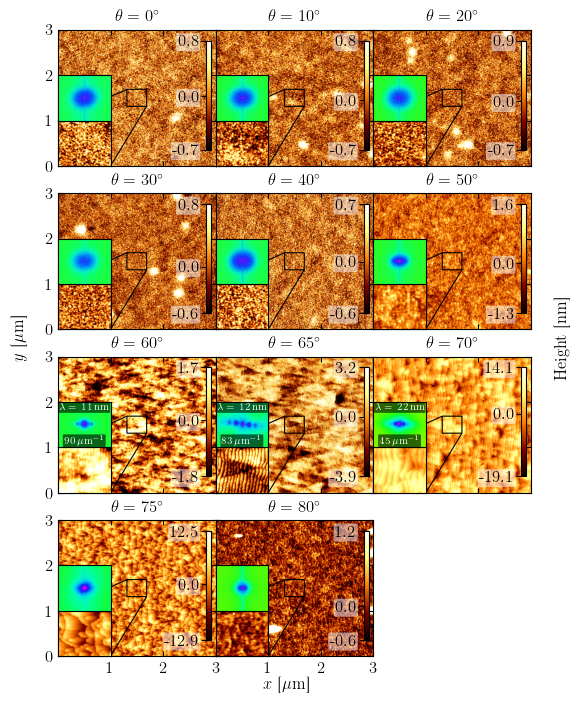

In [15]:
%matplotlib inline
# plot_all_afm_images('AFM/Ripples/3', 'Ripples', n_cols=3, colormap='afmhot', norm_type='linear', arrow_type='left')
plot_all_afm_images('AFM/Ripples/3', 'Ripples', n_cols=3, colormap='afmhot', norm_type='linear', arrow_type='left', show_fft=True, fft_peaks='fft_peaks.json')
# plot_all_afm_images('AFM/Ripples/30', 'Ripples', n_cols=3, colormap='afmhot', norm_type='linear', arrow_type='left')

In [ ]:
plot_all_afm_images('AFM/Time Series/Mapping', 'Dots', n_cols=3, colormap='afmhot', norm_type='linear', arrow_type='clockwise', title_mode='time', time_unit='min')

In [65]:
def plot_psd_grid(psd_dir='AFM/Ripples/psd/Combined',
                  targets=None,
                  save_pgf=False,
                  page_width_pt=441.01773,
                  a4_height_mm=297.0,
                  margin_mm=25.0,
                  n_cols=2,
                  combined=False):
    """
    Log-log PSD plots.
    If combined=True, all curves are plotted on a single axis.
    Otherwise, a multi-panel grid is produced (one panel per file).
    Adds per-panel annotations:
      θ (from leading number in .psd filename)
      Rq roughness (from header line: 'roughness (rms): Rq = (0.23 ± 0.01) nm')
    """
    text_height_mm = a4_height_mm - 2 * margin_mm
    page_height_pt = text_height_mm / 25.4 * 72.27
    fig_width_in = page_width_pt / 72.27
    fig_height_in = page_height_pt / 72.27 * 0.8

    if not os.path.isdir(psd_dir):
        alt = psd_dir.replace('Combined', 'combined')
        if os.path.isdir(alt):
            psd_dir = alt
        else:
            print(f"Directory not found: {psd_dir}")
            return

    # Collect all .psd files, extract leading number for sorting/labelling
    psd_files = [f for f in os.listdir(psd_dir) if f.lower().endswith('.psd')]
    if not psd_files:
        print(f"No .psd files found in {psd_dir}")
        return

    file_entries = []
    for fname in psd_files:
        m = re.match(r'(\d+)', fname)
        angle = int(m.group(1)) if m else 0
        file_entries.append((angle, os.path.join(psd_dir, fname)))

    file_entries.sort(key=lambda t: t[0])

    # Optional filtering by targets
    if targets is not None:
        file_entries = [(a, p) for a, p in file_entries if a in targets]

    if not file_entries:
        print("No matching PSD files found.")
        return

    # Matches both 'Rq = (0.23 ± 0.01) nm' and 'Rq=1.19 nm'
    rq_pattern_pm = re.compile(r'Rq\s*=\s*\(\s*([0-9]*\.?[0-9]+)\s*±\s*([0-9]*\.?[0-9]+)\s*\)\s*nm', re.IGNORECASE)
    rq_pattern_simple = re.compile(r'Rq\s*=\s*([0-9]*\.?[0-9]+)\s*nm', re.IGNORECASE)

    def _read_psd_file(file_path):
        freqs, psd, std = [], [], []
        rq_val, rq_err = None, None
        with open(file_path, 'r', encoding='utf-8') as f:
            lines = f.readlines()
        start = 0
        for i, line in enumerate(lines):
            m_rq = rq_pattern_pm.search(line)
            if m_rq:
                try:
                    rq_val = float(m_rq.group(1))
                    rq_err = float(m_rq.group(2))
                except ValueError:
                    rq_val, rq_err = None, None
            else:
                m_rq2 = rq_pattern_simple.search(line)
                if m_rq2:
                    try:
                        rq_val = float(m_rq2.group(1))
                        rq_err = None
                    except ValueError:
                        rq_val, rq_err = None, None
            if 'spatial frequency' in line.lower():
                start = i + 1
                break
        for line in lines[start:]:
            line = line.strip()
            if not line or not (line[0].isdigit() or line[0] in '+-.'):
                continue
            parts = re.split(r'\s+', line)
            if len(parts) >= 2:
                try:
                    freqs.append(float(parts[0]))
                    psd.append(float(parts[1]))
                    std.append(float(parts[2]) if len(parts) >= 3 else 0.0)
                except ValueError:
                    pass
        f_arr = np.array(freqs, float)
        p_arr = np.array(psd, float)
        s_arr = np.array(std, float)
        mask = (f_arr > 0) & (p_arr > 0) & (s_arr >= 0) & ((p_arr - s_arr) > 0)
        return f_arr[mask], p_arr[mask], s_arr[mask], rq_val, rq_err

    series = []
    for angle, path in file_entries:
        f, p, s, rq_val, rq_err = _read_psd_file(path)
        if f.size:
            series.append({'angle': angle, 'f': f, 'p': p, 's': s, 'rq': rq_val, 'rq_err': rq_err})
    if not series:
        print("No valid PSD data after filtering.")
        return

    # ── Combined: all curves on one axis ──
    if combined:
        fig, ax = plt.subplots(figsize=(fig_width_in, fig_height_in * 0.45))
        cmap = plt.cm.viridis
        colors = cmap(np.linspace(0, 1, len(series)))
        for idx, item in enumerate(series):
            f = item['f']; p = item['p']; s = item['s']
            color = colors[idx]
            nonzero = s > 0
            if np.any(nonzero):
                ax.errorbar(f[nonzero], p[nonzero], yerr=s[nonzero], fmt='none',
                            ecolor=color, elinewidth=0.6, capsize=1, capthick=0.6, alpha=0.5, zorder=1)
            ax.plot(f, p, '-', ms=2, lw=1.2, color=color,
                    label=rf'$\theta={item["angle"]}°$', zorder=2)
        ax.set_xscale('log')
        ax.set_yscale('log')
        ax.set_xlabel(r'Spatial Frequency [$\mu$m$^{-1}$]')
        ax.set_ylabel(r'Isotropic PASD [nm$^4$]')
        ax.tick_params(which='both', direction='in', top=True, right=True)
        ax.legend(fontsize=8, ncol=2, loc='best', framealpha=0.8)
        fig.tight_layout()

        if save_pgf:
            os.makedirs('PASDpgf', exist_ok=True)
            out_path = os.path.join('PASDpgf', 'pasd_combined.pgf')
            plt.savefig(out_path, format='pgf', bbox_inches='tight')
            print(f"Saved: {out_path}")

        plt.show()
        plt.close(fig)
        return

    # ── Grid: one panel per file ──
    n = len(series)
    n_cols = max(1, int(n_cols))
    n_rows = (n + n_cols - 1) // n_cols

    f_min = min(float(item['f'].min()) for item in series)
    f_max = max(float(item['f'].max()) for item in series)

    fig, axes = plt.subplots(
        n_rows, n_cols,
        figsize=(fig_width_in, fig_height_in),
        sharex=False,
        sharey=False,
        gridspec_kw={'hspace': 0.0, 'wspace': 0.18}
    )
    axes = np.atleast_2d(axes)

    for idx, item in enumerate(series):
        r = idx % n_rows
        c = idx // n_rows
        ax = axes[r, c]
        f = item['f']; p = item['p']; s = item['s']
        nonzero = s > 0
        if np.any(nonzero):
            ax.errorbar(f[nonzero], p[nonzero], xerr=None, yerr=s[nonzero], fmt='none',
                        ecolor='k', elinewidth=0.8, capsize=1, capthick=0.8, zorder=1)
        ax.plot(f, p,  ms=2, color='k', zorder=2)
        ax.set_xscale('log')
        ax.set_yscale('log')
        ax.set_xlim(f_min, f_max)

        angle = item['angle']
        ax.text(0.95, 0.94, rf'$\theta={angle}^{{\circ}}$', transform=ax.transAxes,
                ha='right', va='top', fontsize=10,
                bbox=dict(boxstyle='round,pad=0.25', fc='white', ec='black', lw=0.6, alpha=0.8))

        rq_val = item['rq']; rq_err = item['rq_err']
        if rq_val is not None:
            ax.text(0.05, 0.06,
                    rf'$R_q={rq_val:.2f}\pm{(rq_err if rq_err is not None else 0):.2f}$ nm',
                    transform=ax.transAxes, ha='left', va='bottom', fontsize=9,
                    bbox=dict(boxstyle='round,pad=0.25', fc='white', ec='black', lw=0.6, alpha=0.8))
        else:
            ax.text(0.98, 0.94, r'$R_q$ n/a', transform=ax.transAxes,
                    ha='right', va='top', fontsize=10, color='gray')

    total_axes = n_rows * n_cols
    for idx in range(n, total_axes):
        r = idx % n_rows
        c = idx // n_rows
        axes[r, c].set_visible(False)

    for idx, item in enumerate(series):
        r = idx % n_rows
        c = idx // n_rows
        ax = axes[r, c]

        ax.tick_params(which='both', direction='in', top=True, right=True, bottom=True, left=True)

        next_idx = idx + 1
        if next_idx < len(series):
            next_c = next_idx // n_rows
            if next_c != c:
                ax.tick_params(labelbottom=True)
            else:
                ax.tick_params(labelbottom=False)
        else:
            ax.tick_params(labelbottom=True)

    fig.text(0.5, 0.03, r'Spatial Frequency [$\mu$m$^{-1}$]', ha='center', va='center')
    fig.text(0.035, 0.5, r'Isotropic PASD [nm$^4$]', va='center', rotation='vertical')

    fig.subplots_adjust(left=0.12, right=0.98, top=0.995, bottom=0.07, hspace=0.0)

    if save_pgf:
        os.makedirs('PASDpgf', exist_ok=True)
        out_path = os.path.join('PASDpgf', f'pasd_grid_fullpage_{n_cols}col.pgf')
        plt.savefig(out_path, format='pgf', bbox_inches='tight')
        print(f"Saved: {out_path}")

    plt.show()
    plt.close(fig)

In [168]:
def compute_isotropic_pasd(afm_dir='AFM/Ripples/3',
                           targets=None,
                           n_bins=100,
                           window='hann',
                           detect_peaks=True,
                           peak_prominence=0.1):
    """
    Compute the isotropic (azimuthally averaged) Power Spectral Density
    directly from AFM .asc files using load_afm_data.
    """
    asc_files = sorted(
        [f for f in os.listdir(afm_dir) if f.lower().endswith('.asc')],
        key=get_afm_sort_key
    )
    if not asc_files:
        print(f"No .asc files found in {afm_dir}")
        return []

    results = []
    for fname in asc_files:
        m = re.match(r'(\d+)', fname)
        angle = int(m.group(1)) if m else 0
        if targets is not None and angle not in targets:
            continue

        header, data = load_afm_data(os.path.join(afm_dir, fname))
        if data is None:
            continue

        ny, nx = data.shape
        x_len_nm = float(header.get('x-length', 1))
        y_len_nm = float(header.get('y-length', 1))
        Lx = x_len_nm / 1000.0  # µm
        Ly = y_len_nm / 1000.0  # µm
        dx = Lx / nx  # µm per pixel
        dy = Ly / ny

        # --- Clean & detrend ---
        z = data.copy()
        nan_mask = np.isnan(z)
        z_mean = np.nanmean(z)
        if np.any(nan_mask):
            z[nan_mask] = z_mean
        z = z - np.mean(z)  # remove DC

        # Roughness (before windowing)
        rq = np.sqrt(np.mean(z**2))

        # --- Window ---
        if window == 'hann':
            win = np.outer(np.hanning(ny), np.hanning(nx))
            S1 = np.sum(win)
            S2 = np.sum(win**2)
        else:
            win = np.ones((ny, nx))
            S1 = nx * ny
            S2 = nx * ny

        z_win = z * win

        # --- 2D FFT & properly normalised PSD ---
        fft2d = np.fft.fftshift(np.fft.fft2(z_win))
        psd_2d = (dx * dy) / (S2) * np.abs(fft2d)**2

        # Spatial frequency grids
        freq_x = np.fft.fftshift(np.fft.fftfreq(nx, d=dx))
        freq_y = np.fft.fftshift(np.fft.fftfreq(ny, d=dy))
        FX, FY = np.meshgrid(freq_x, freq_y)
        F_radial = np.sqrt(FX**2 + FY**2)

        # --- Azimuthal averaging ---
        f_max = min(freq_x.max(), freq_y.max())
        df = 1.0 / max(Lx, Ly)
        bin_edges = np.linspace(df, f_max, n_bins + 1)
        bin_centres = 0.5 * (bin_edges[:-1] + bin_edges[1:])
        psd_iso = np.zeros(n_bins)

        for ib in range(n_bins):
            mask = (F_radial >= bin_edges[ib]) & (F_radial < bin_edges[ib + 1])
            if np.any(mask):
                psd_iso[ib] = np.mean(psd_2d[mask])

        # Remove empty bins
        valid = psd_iso > 0
        freq_valid = bin_centres[valid]
        psd_valid = psd_iso[valid]
        
        entry = {
            'angle': angle,
            'freq': freq_valid,
            'psd': psd_valid,
            'rq': rq,
            'fname': fname,
        }

        # --- Peak Detection Strategy ---
        # 1. Only detect for 60, 65, 70
        if detect_peaks and len(psd_valid) > 0 and angle in [60, 65, 70]:
            log_psd = np.log10(psd_valid)
            
            # --- Specific Tuning for 70 degrees ---
            if angle == 70:
                # Look specifically in 20-30 range with lower prominence
                # First try detecting in the specific window [15, 35] to be safe
                indices_in_window = np.where((freq_valid >= 18) & (freq_valid <= 35))[0]
                
                if len(indices_in_window) > 0:
                     # Detect peaks within this slice of the array
                    log_psd_slice = log_psd[indices_in_window]
                    peaks_slice, props_slice = find_peaks(log_psd_slice, prominence=0.01) # Very sensitive
                    
                    # Map back to original indices
                    peaks = indices_in_window[peaks_slice]
                    prominences = props_slice['prominences']
                else:
                    peaks = np.array([], dtype=int)
                    prominences = np.array([])
            
            else:
                # --- Standard Tuning for 60, 65 ---
                peaks, properties = find_peaks(log_psd, prominence=peak_prominence)
                prominences = properties['prominences']

            # Filter out very low freq noise (< 10) just in case
            if len(peaks) > 0:
                valid_mask = freq_valid[peaks] > 10
                peaks = peaks[valid_mask]
                prominences = prominences[valid_mask]

            entry['peaks'] = {
                'indices': peaks,
                'freqs': freq_valid[peaks],
                'psd_vals': psd_valid[peaks],
                'prominences': prominences
            }

        results.append(entry)

    print(f"Computed isotropic PASD for {len(results)} files from {afm_dir}")
    return results


def plot_computed_pasd(results, combined=True, save_pgf=False, n_cols=2,
                       page_width_pt=441.01773, show_peaks=True):
    """
    Plot PASD results from compute_isotropic_pasd().
    combined=True  → all curves on one axis
    combined=False → grid of panels
    show_peaks=True → mark detected peaks if present
    """
    if not results:
        print("No data to plot.")
        return

    fig_width_in = page_width_pt / 72.27

    if combined:
        fig, ax = plt.subplots(figsize=(fig_width_in, fig_width_in * 0.55))
        cmap = plt.cm.tab10
        colors = cmap(np.linspace(0, 1, len(results)))
        for idx, item in enumerate(results):
            color = colors[idx]
            ax.plot(item['freq'], item['psd'], '-', lw=1.2, color=color,
                    label=rf'$\theta={item["angle"]}°$')
            
            # Plot peaks
            if show_peaks and 'peaks' in item:
                peaks = item['peaks']
                if len(peaks['indices']) > 0:
                    ax.plot(peaks['freqs'], peaks['psd_vals'], 
                            marker='v',          
                            linestyle='None', 
                            markersize=6,          # Smaller size
                            markerfacecolor='white', # White inside
                            markeredgecolor=color,   # Outline color matches line
                            markeredgewidth=1.2)     # Slightly thicker outline

                    # Add text annotation
                    for fx, fy in zip(peaks['freqs'], peaks['psd_vals']):
                        wavelength = 1000.0 / fx
                        
                        # --- Custom Label Placement ---
                        # Default settings (used for 60, 70, etc.)
                        xytext_offset = (0, 8)       # Above
                        ha_align = 'center'
                        va_align = 'bottom'
                        
                        # Special case for 65 degrees: Place to the right
                        if item['angle'] == 65:
                            xytext_offset = (8, 0)   # Right side
                            ha_align = 'left'
                            va_align = 'center'
                        # ------------------------------

                        # Using siunitx \SI
                        label_str = rf"\SI{{{fx:.1f}}}{{\mu\meter^{{-1}}}} / \SI{{{wavelength:.0f}}}{{\nano\meter}}"
                        
                        ax.annotate(label_str,
                                    (fx, fy),
                                    xytext=xytext_offset, 
                                    textcoords='offset points',
                                    ha=ha_align, va=va_align,
                                    fontsize=8, color=color)

        ax.set_xscale('log')
        ax.set_yscale('log')
        # ax.set_xlim(9, 121)
        # ax.set_ylim(1e-7, 1e-1)
        
        # Axis labels using siunitx units
        ax.set_xlabel(r'Spatial Frequency $[\si{\mu\meter^{-1}}]$')
        ax.set_ylabel(r'Isotropic PASD $[\si{\nano\meter^4}]$')
        
        ax.tick_params(which='both', direction='in', top=True, right=True)
        ax.legend(fontsize=10, ncol=2, loc='best', framealpha=0.8)
        fig.tight_layout()
    else:
        n = len(results)
        n_cols = max(1, int(n_cols))
        n_rows = (n + n_cols - 1) // n_cols
        fig, axes = plt.subplots(n_rows, n_cols,
                                 figsize=(fig_width_in, fig_width_in * 0.5 * n_rows / n_cols),
                                 sharex=True, sharey=True,
                                 gridspec_kw={'hspace': 0.0, 'wspace': 0.18})
        axes = np.atleast_2d(axes)
        for idx, item in enumerate(results):
            r = idx % n_rows
            c = idx // n_rows
            ax = axes[r, c]
            color = 'k'
            ax.plot(item['freq'], item['psd'], '.', ms=2, color=color)
            
            # Plot peaks
            if show_peaks and 'peaks' in item:
                peaks = item['peaks']
                if len(peaks['indices']) > 0:
                    ax.plot(peaks['freqs'], peaks['psd_vals'], 
                            marker='v',          
                            linestyle='None', 
                            markersize=6,
                            markerfacecolor='white', 
                            markeredgecolor=color, 
                            markeredgewidth=1.2)
                    
                    # Annotate primary peak wavelength
                    if len(peaks['freqs']) > 0:
                        # Find the most prominent peak
                        proms = peaks['prominences']
                        best_idx = np.argmax(proms)
                        best_freq = peaks['freqs'][best_idx]
                        wavelength = 1000.0 / best_freq # nm
                        
                        label_str = rf"$\lambda \approx \SI{{{wavelength:.0f}}}{{\nano\meter}}$"
                        
                        ax.text(0.95, 0.80, label_str,
                                transform=ax.transAxes, ha='right', va='top', fontsize=9,
                                color='red')

            ax.set_xscale('log')
            ax.set_yscale('log')
            ax.text(0.95, 0.94, rf'$\theta=\SI{{{item["angle"]}}}{{\degree}}$',
                    transform=ax.transAxes, ha='right', va='top', fontsize=10,
                    bbox=dict(boxstyle='round,pad=0.25', fc='white', ec='black', lw=0.6, alpha=0.8))
            ax.text(0.05, 0.06, rf'$R_q=\SI{{{item["rq"]:.2f}}}{{\nano\meter}}$',
                    transform=ax.transAxes, ha='left', va='bottom', fontsize=9,
                    bbox=dict(boxstyle='round,pad=0.25', fc='white', ec='black', lw=0.6, alpha=0.8))
            ax.tick_params(which='both', direction='in', top=True, right=True)
        for idx in range(n, n_rows * n_cols):
            r = idx % n_rows
            c = idx // n_rows
            axes[r, c].set_visible(False)
        fig.text(0.5, 0.02, r'Spatial Frequency $[\si{\mu\meter^{-1}}]$', ha='center')
        fig.text(0.02, 0.5, r'Isotropic PASD $[\si{\nano\meter^4}]$', va='center', rotation='vertical')
        fig.subplots_adjust(left=0.1, right=0.98, top=0.995, bottom=0.07)

    if save_pgf:
        os.makedirs('PASDpgf', exist_ok=True)
        tag = 'combined' if combined else f'grid_{n_cols}col'
        out = os.path.join('PASDpgf', f'pasd_computed_{tag}.pgf')
        plt.savefig(out, format='pgf', bbox_inches='tight')
        print(f"Saved: {out}")

    plt.show()
    plt.close(fig)

Computed isotropic PASD for 11 files from AFM/Ripples/3
Computed isotropic PASD for 4 files from AFM/Ripples/3/nice


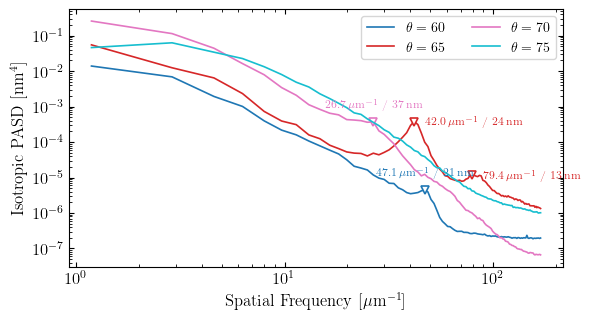

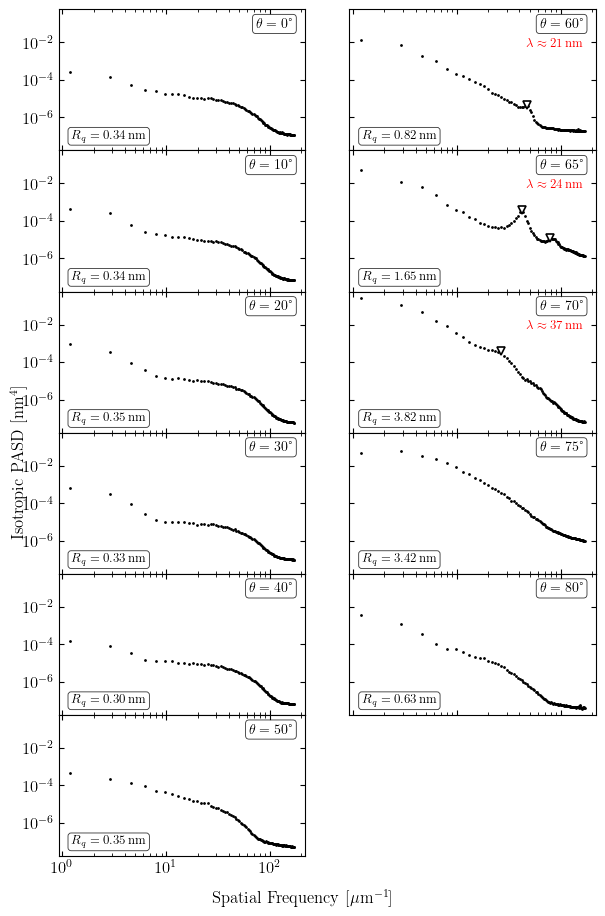

In [169]:
# Compute isotropic PASD directly from AFM data
pasd_results = compute_isotropic_pasd('AFM/Ripples/3')
plot_computed_pasd(compute_isotropic_pasd('AFM/Ripples/3/nice'), combined=True)
plot_computed_pasd(pasd_results, combined=False, n_cols=2)

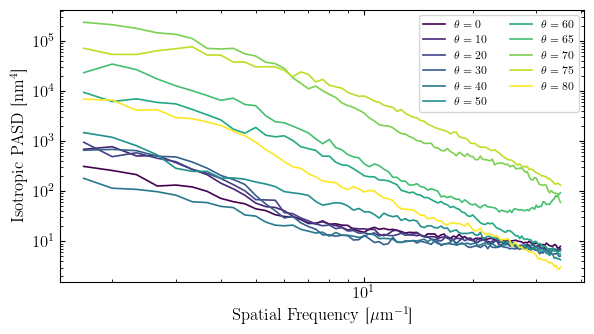

In [35]:
plot_psd_grid('AFM/Ripples/psd/3', save_pgf=False, n_cols=2, combined=True)

Found 18 histogram .asc files. Processing in order:
  C1000_1.1-3mu-1.spm.urz Diameter.asc
  C1000_1.1-30mu-1.spm.drz Diameter.asc
  C1000_1.1-30mu-2.spm.urz Diameter.asc
  C1000_1.2-3mu-1.spm.dtz Diameter.asc
  C1000_1.2-3mu-2.spm.drz Diameter.asc
  C1000_1.2-30mu-1.spm.dtz Diameter.asc
  C1000_1.2-30mu-2.drz Diameter.asc
  C1000_1.3-3mu-1.spm.dtz Diameter.asc
  C1000_1.3-3mu-2.spm.drz Diameter.asc
  C1000_1.3-30mu-1.spm.dtz Diameter.asc
  C1000_1.3-30mu-2.spm.drz Diameter.asc
  C1000_1.4-3mu-1.spm.dtz Diameter.asc
  C1000_1.4-3mu-2.spm.drz Diameter.asc
  C1000_1.4-30mu-1.spm.dtz Diameter.asc
  C1000_1.4-30mu-2.spm.drz Diameter.asc
  C1000_1.6-3mu-1.spm.dtz Diameter.asc
  C1000_1.6-3mum-2.spm.drz Diameter.asc
  C1000_1.6-30mu-1.spm.utz Diameter.asc

--- Processing C1000_1.1-3mu-1.spm.urz Diameter.asc ---


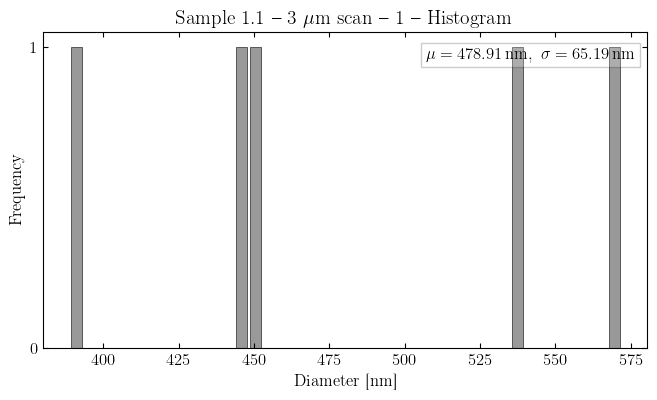

Average diameter (μ): 478.91 nm
Standard deviation (σ): 65.19 nm
Plot saved to Histogrampgf/1_1_3mu_1_histogram.pgf

--- Processing C1000_1.1-30mu-1.spm.drz Diameter.asc ---


<Figure size 640x480 with 0 Axes>

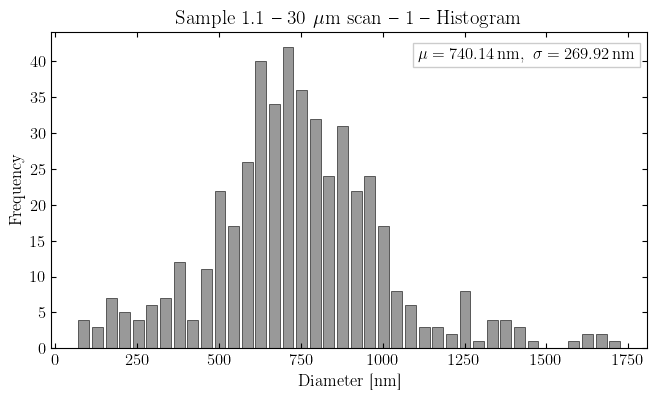

Average diameter (μ): 740.14 nm
Standard deviation (σ): 269.92 nm
Plot saved to Histogrampgf/1_1_30mu_1_histogram.pgf

--- Processing C1000_1.1-30mu-2.spm.urz Diameter.asc ---


<Figure size 640x480 with 0 Axes>

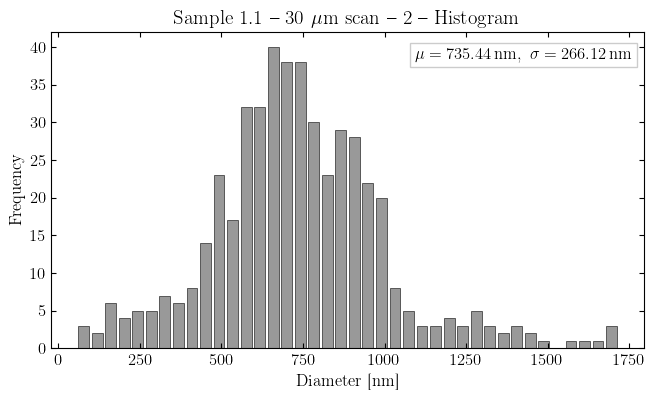

Average diameter (μ): 735.44 nm
Standard deviation (σ): 266.12 nm
Plot saved to Histogrampgf/1_1_30mu_2_histogram.pgf

--- Processing C1000_1.2-3mu-1.spm.dtz Diameter.asc ---


<Figure size 640x480 with 0 Axes>

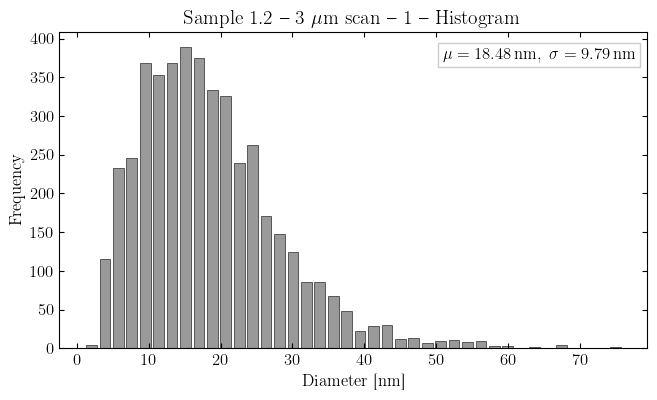

Average diameter (μ): 18.48 nm
Standard deviation (σ): 9.79 nm
Plot saved to Histogrampgf/1_2_3mu_1_histogram.pgf

--- Processing C1000_1.2-3mu-2.spm.drz Diameter.asc ---


<Figure size 640x480 with 0 Axes>

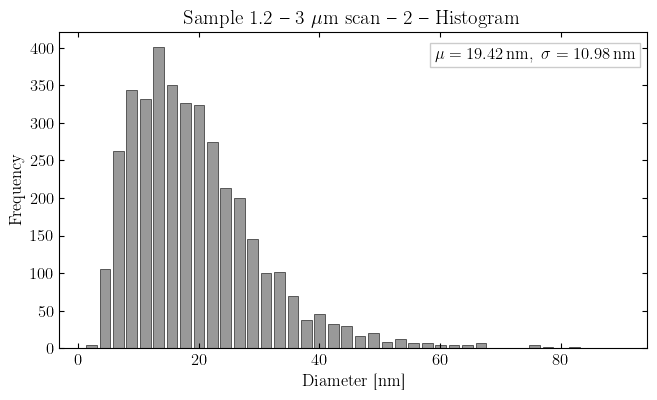

Average diameter (μ): 19.42 nm
Standard deviation (σ): 10.98 nm
Plot saved to Histogrampgf/1_2_3mu_2_histogram.pgf

--- Processing C1000_1.2-30mu-1.spm.dtz Diameter.asc ---


<Figure size 640x480 with 0 Axes>

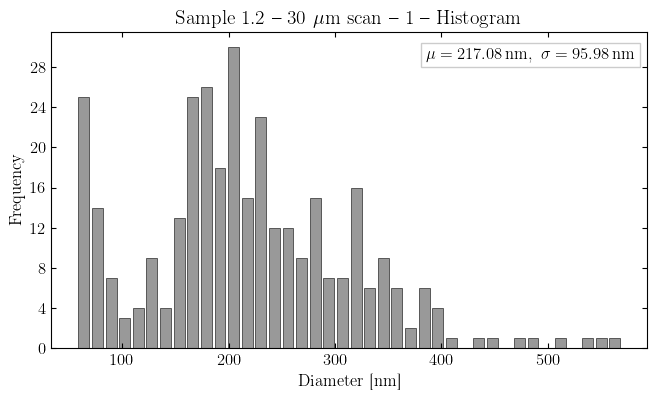

Average diameter (μ): 217.08 nm
Standard deviation (σ): 95.98 nm
Plot saved to Histogrampgf/1_2_30mu_1_histogram.pgf

--- Processing C1000_1.2-30mu-2.drz Diameter.asc ---


<Figure size 640x480 with 0 Axes>

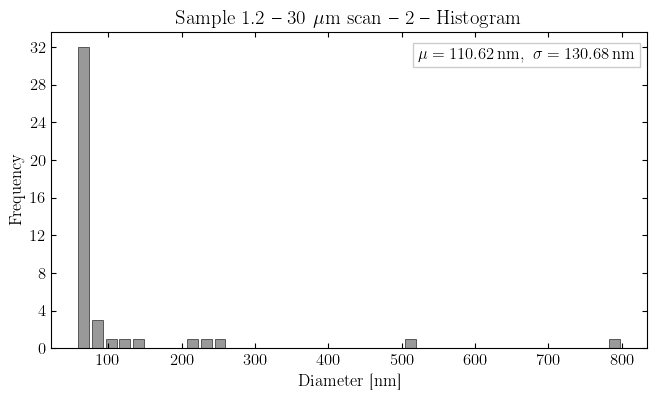

Average diameter (μ): 110.62 nm
Standard deviation (σ): 130.68 nm
Plot saved to Histogrampgf/1_2_30mu_2_histogram.pgf

--- Processing C1000_1.3-3mu-1.spm.dtz Diameter.asc ---


<Figure size 640x480 with 0 Axes>

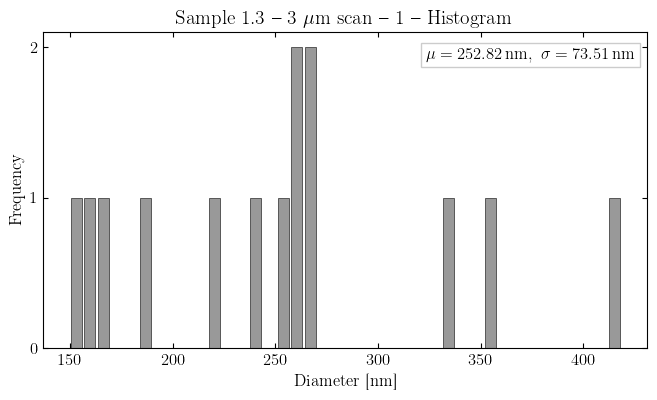

Average diameter (μ): 252.82 nm
Standard deviation (σ): 73.51 nm
Plot saved to Histogrampgf/1_3_3mu_1_histogram.pgf

--- Processing C1000_1.3-3mu-2.spm.drz Diameter.asc ---


<Figure size 640x480 with 0 Axes>

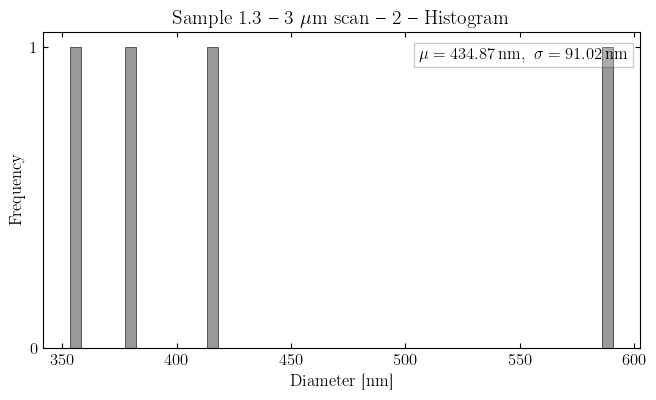

Average diameter (μ): 434.87 nm
Standard deviation (σ): 91.02 nm
Plot saved to Histogrampgf/1_3_3mu_2_histogram.pgf

--- Processing C1000_1.3-30mu-1.spm.dtz Diameter.asc ---


<Figure size 640x480 with 0 Axes>

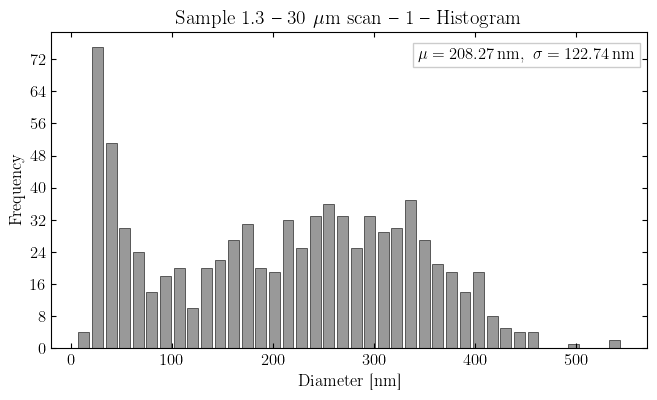

Average diameter (μ): 208.27 nm
Standard deviation (σ): 122.74 nm
Plot saved to Histogrampgf/1_3_30mu_1_histogram.pgf

--- Processing C1000_1.3-30mu-2.spm.drz Diameter.asc ---


<Figure size 640x480 with 0 Axes>

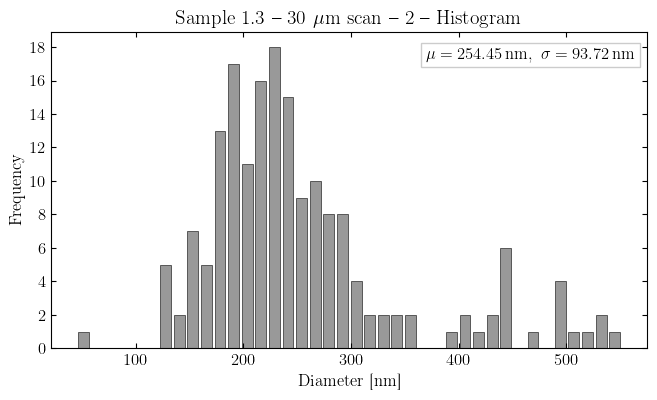

Average diameter (μ): 254.45 nm
Standard deviation (σ): 93.72 nm
Plot saved to Histogrampgf/1_3_30mu_2_histogram.pgf

--- Processing C1000_1.4-3mu-1.spm.dtz Diameter.asc ---


<Figure size 640x480 with 0 Axes>

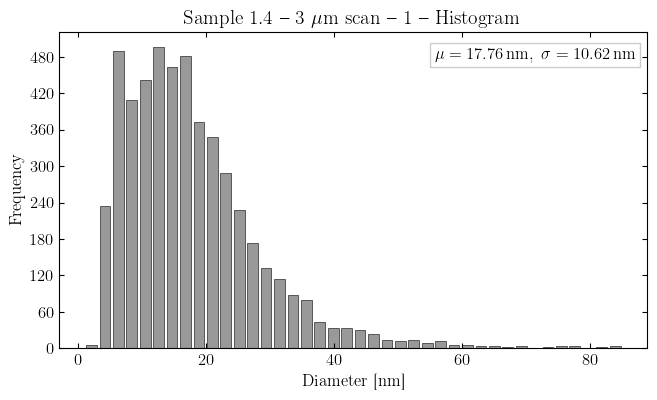

Average diameter (μ): 17.76 nm
Standard deviation (σ): 10.62 nm
Plot saved to Histogrampgf/1_4_3mu_1_histogram.pgf

--- Processing C1000_1.4-3mu-2.spm.drz Diameter.asc ---


<Figure size 640x480 with 0 Axes>

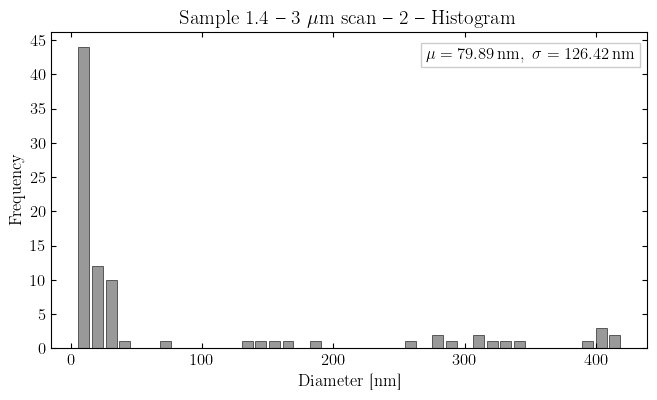

Average diameter (μ): 79.89 nm
Standard deviation (σ): 126.42 nm
Plot saved to Histogrampgf/1_4_3mu_2_histogram.pgf

--- Processing C1000_1.4-30mu-1.spm.dtz Diameter.asc ---


<Figure size 640x480 with 0 Axes>

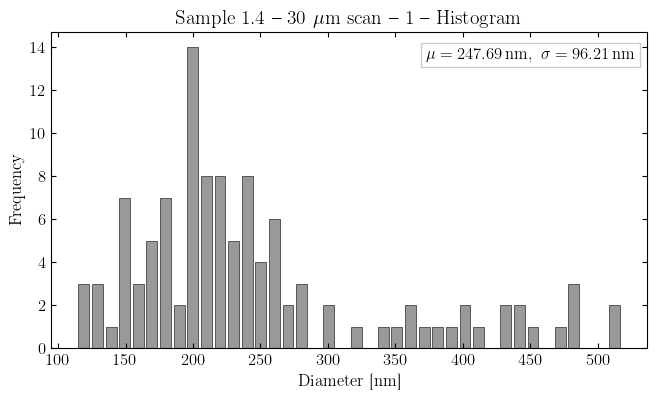

Average diameter (μ): 247.69 nm
Standard deviation (σ): 96.21 nm
Plot saved to Histogrampgf/1_4_30mu_1_histogram.pgf

--- Processing C1000_1.4-30mu-2.spm.drz Diameter.asc ---


<Figure size 640x480 with 0 Axes>

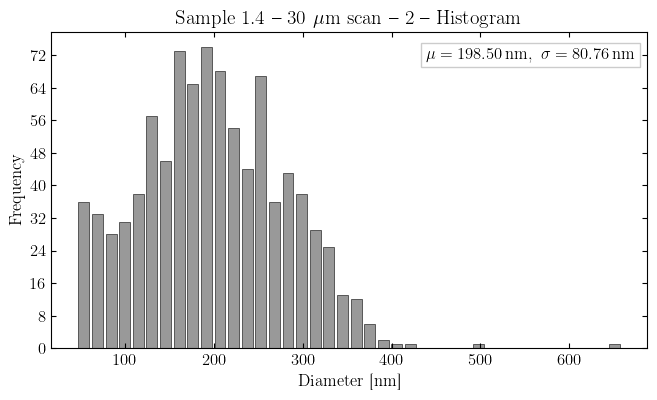

Average diameter (μ): 198.50 nm
Standard deviation (σ): 80.76 nm
Plot saved to Histogrampgf/1_4_30mu_2_histogram.pgf

--- Processing C1000_1.6-3mu-1.spm.dtz Diameter.asc ---


<Figure size 640x480 with 0 Axes>

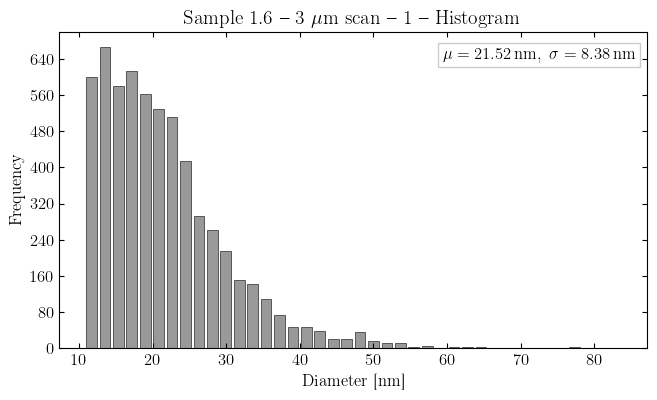

Average diameter (μ): 21.52 nm
Standard deviation (σ): 8.38 nm
Plot saved to Histogrampgf/1_6_3mu_1_histogram.pgf

--- Processing C1000_1.6-3mum-2.spm.drz Diameter.asc ---


<Figure size 640x480 with 0 Axes>

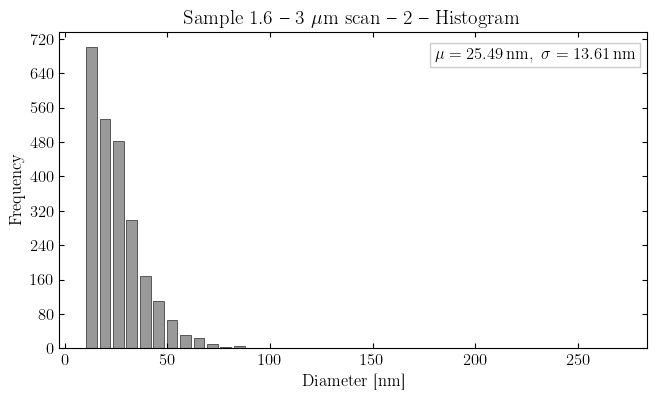

Average diameter (μ): 25.49 nm
Standard deviation (σ): 13.61 nm
Plot saved to Histogrampgf/1_6_3mu_2_histogram.pgf

--- Processing C1000_1.6-30mu-1.spm.utz Diameter.asc ---


<Figure size 640x480 with 0 Axes>

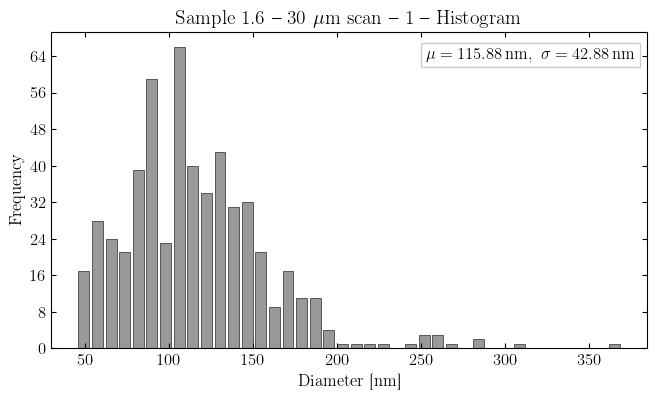

Average diameter (μ): 115.88 nm
Standard deviation (σ): 42.88 nm
Plot saved to Histogrampgf/1_6_30mu_1_histogram.pgf


<Figure size 640x480 with 0 Axes>

In [ ]:
def load_histogram_data(file_path):
    """
    Loads histogram data from ASCII files.
    """
    if not os.path.exists(file_path):
        print(f"Error: File not found at {file_path}")
        return None, None

    try:
        # Try to load the data directly
        data = np.loadtxt(file_path, skiprows=0)
        
        # If it's a 2-column format (bin_centers, counts)
        if data.ndim == 2 and data.shape[1] >= 2:
            x = data[:, 0]
            y = data[:, 1]
            return x, y
        # If it's a 1-column format (just counts, assume bins are indices)
        elif data.ndim == 1:
            x = np.arange(len(data))
            y = data
            return x, y
        else:
            print(f"Unexpected data format in {file_path}")
            return None, None
            
    except Exception as e:
        print(f"Error loading data from {file_path}: {e}")
        return None, None

def get_histogram_sort_key(file_path):
    # Extract just the filename from the full path
    filename = os.path.basename(file_path)
    
    # Handle the filename format using the same regex pattern
    pattern = r'C1000_(\d+\.\d+)-(\d+)mum?-(\d+).*\.asc'
    match = re.match(pattern, filename)
    
    if match:
        sample_number = float(match.group(1))  # Convert to float for proper sorting
        size = int(match.group(2))
        index = int(match.group(3))
        # Sort by sample number first, then by size, then by index
        return (sample_number, size, index)
    
    # Fallback for files that don't match the pattern
    return (float('inf'), 0, 0)

def plot_histogram(file_path):
    """
    Loads and plots a histogram from ASCII file with diameter statistics.
    """
    x, y = load_histogram_data(file_path)
    
    if x is None or y is None:
        print(f"Could not plot the data for {os.path.basename(file_path)}.")
        return

    # Calculate weighted average and standard deviation
    # Assuming x represents diameter bin centers and y represents frequencies
    total_count = np.sum(y)
    if total_count > 0:
        # Weighted average diameter
        avg_diameter = np.sum(x * y) / total_count
        
        # Weighted standard deviation
        variance = np.sum(y * (x - avg_diameter)**2) / total_count
        std_diameter = np.sqrt(variance)
    else:
        avg_diameter = 0
        std_diameter = 0

    # Extract the desired part of the filename for the title
    basename = os.path.basename(file_path)
    title = basename  # Default to full filename if pattern not found
    
    # Handle the filename format using the same regex pattern
    if "C1000_" in basename:
        # Use the flexible pattern that works for all files
        pattern = r'C1000_(\d+\.\d+)-(\d+)mum?-(\d+).*\.asc'
        match = re.match(pattern, basename)
        
        if match:
            sample_number = match.group(1)  # e.g., "1.1"
            size = match.group(2)           # e.g., "30"
            index = match.group(3)          # e.g., "1"
            title = f"Sample {sample_number} -- {size} $\\mu$m scan -- {index} -- Histogram"
        else:
            # Fallback for other patterns
            parts = basename.split("C1000_")
            if len(parts) > 1:
                segment_after_c1000 = parts[1]
                # Find the end of the desired segment (before the file extension)
                end_index = len(segment_after_c1000)
                for i, char in enumerate(segment_after_c1000):
                    if char == '.':  # Stop at file extension
                        end_index = i
                        break
                title_part = segment_after_c1000[:end_index]
                title = f"Sample {title_part} -- Histogram"

    # Create a new Matplotlib figure and axes
    fig, ax = plt.subplots(figsize=set_size(540.6, fraction=0.9))

    # Plot the histogram as bars
    # Calculate bin width for proper bar display
    if len(x) > 1:
        # Use the difference between consecutive x values as bin width
        bin_width = np.diff(x)[0]
    else:
        bin_width = 1.0  # Default width if only one data point
    
    # Plot as histogram bars
    ax.bar(x, y, width=bin_width * 0.8, alpha=0.8, color='gray', edgecolor='black', linewidth=0.5)

    # Add titles and labels
    ax.set_title(title)
    ax.set_xlabel(r'Diameter [nm]')
    ax.set_ylabel(r'Frequency')

    # Add combined statistics annotation using Greek letters
    if total_count > 0:
        stats_text = f"$\\mu = {avg_diameter:.2f} \\,\\mathrm{{nm}}, \\ \\sigma = {std_diameter:.2f} \\,\\mathrm{{nm}}$"
        
        # Position annotation on the plot
        ax.annotate(stats_text, xy=(0.98, 0.95), xycoords='axes fraction',
                   size=12, ha='right', va='top',
                   bbox=dict(boxstyle='square', fc='white', alpha=0.2))

    # Set y-axis to display only integer values
    from matplotlib.ticker import MaxNLocator
    ax.yaxis.set_major_locator(MaxNLocator(integer=True))

    # Configure ticks to appear on both sides and face inward
    ax.tick_params(axis='both', which='both', direction='in',
                  top=True, right=True, bottom=True, left=True)

    # Adjust layout to prevent labels from overlapping
    plt.tight_layout()

    # Show the plot
    plt.show()

    # Print statistics to console
    if total_count > 0:
        print(f"Average diameter (μ): {avg_diameter:.2f} nm")
        print(f"Standard deviation (σ): {std_diameter:.2f} nm")
    else:
        print("No data points found for statistics calculation")

    # Create clean filename for saving
    if "C1000_" in basename:
        pattern = r'C1000_(\d+\.\d+)-(\d+)mum?-(\d+).*\.asc'
        match = re.match(pattern, basename)
        if match:
            sample_number = match.group(1).replace('.', '_')
            size = match.group(2)
            index = match.group(3)
            save_title_part = f"{sample_number}_{size}mu_{index}_histogram"
        else:
            save_title_part = basename.replace('.asc', '').replace('.', '_').replace('-', '_') + '_histogram'
    else:
        save_title_part = basename.replace('.asc', '') + '_histogram'
    
    # Define the output directory
    output_dir = 'Histogrampgf'
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
    
    # Save the figure
    output_path = os.path.join(output_dir, f"{save_title_part}.pgf")
    plt.savefig(output_path, format="pgf", dpi=234)
    print(f"Plot saved to {output_path}")
    
    plt.close(fig)
# --- USAGE ---
# Directory containing the histogram files
histogram_directory = 'AFM/Time Series/PnP Analysis'

if os.path.exists(histogram_directory) and os.path.isdir(histogram_directory):
    asc_files = [f for f in os.listdir(histogram_directory) if f.endswith('.asc')]
    
    if not asc_files:
        print(f"No .asc files found in {histogram_directory}")
    else:
        # Create full paths and sort them
        file_paths = [os.path.join(histogram_directory, f) for f in asc_files]
        file_paths.sort(key=get_histogram_sort_key)
        
        print(f"Found {len(file_paths)} histogram .asc files. Processing in order:")
        for file_path in file_paths:
            print(f"  {os.path.basename(file_path)}")
        
        for file_path in file_paths:
            print(f"\n--- Processing {os.path.basename(file_path)} ---")
            plot_histogram(file_path)
else:
    print(f"Directory not found: {histogram_directory}")
    print("Please make sure your histogram files are in the correct directory.")

In [ ]:
import os
import re
from pathlib import Path

def get_pgf_files(directory):
    """Get all PGF files from a directory and sort them."""
    if not os.path.exists(directory):
        return []
    
    pgf_files = [f for f in os.listdir(directory) if f.endswith('.pgf')]
    
    # Sort files using the same pattern as your analysis
    def sort_key(filename):
        pattern = r'(\d+)_(\d+)_(\d+)mu_(\d+)'
        match = re.search(pattern, filename)
        if match:
            return (float(match.group(1) + '.' + match.group(2)), 
                   int(match.group(3)), 
                   int(match.group(4)))
        return (float('inf'), 0, 0)
    
    pgf_files.sort(key=sort_key)
    return pgf_files

def generate_corrected_latex_report():
    """Generate a LaTeX report with only existing files."""
    
    # Get all PGF files that actually exist
    afm_files = get_pgf_files('AFMpgf')
    hist_files = get_pgf_files('Histogrampgf')
    pasd_files = get_pgf_files('PASDpgf')
    
    print(f"Found {len(afm_files)} AFM files")
    print(f"Found {len(hist_files)} histogram files")
    print(f"Found {len(pasd_files)} PASD files")
    
    # Create LaTeX content
    latex_content = r'''
\documentclass[11pt,a4paper]{article}
\usepackage[utf8]{inputenc}
\usepackage[T1]{fontenc}
\usepackage{geometry}
\geometry{margin=2.5cm}

% Fix for mathdefault issues in PGF files
\providecommand{\mathdefault}[1]{#1}

% Graphics and figures
\usepackage{graphicx}
\usepackage{pgfplots}
\pgfplotsset{compat=1.16}
\usepackage{caption}
\usepackage{subcaption}
\usepackage{float}

% Math packages
\usepackage{amsmath}
\usepackage{amsfonts}
\usepackage{siunitx}

% Other useful packages
\usepackage{hyperref}
\usepackage{cite}
\usepackage{booktabs}
\usepackage{array}
\usepackage{longtable}

\title{AFM Analysis Results: Comprehensive Surface Characterization}
\author{AFM Data Analysis}
\date{\today}

\begin{document}

\maketitle

\tableofcontents
\newpage

\section{Introduction}

This report presents a comprehensive analysis of Atomic Force Microscopy (AFM) data, including surface topography characterization, particle size distribution analysis, and Power Spectral Density (PSD) measurements.

\section{Results}

'''

    # Add AFM section with only existing files
    if afm_files:
        latex_content += r'''
\subsection{AFM Surface Topography}

The following figures show the surface topography of different samples:

'''
        for i, filename in enumerate(afm_files):
            # Extract sample info from filename
            pattern = r'(\d+)_(\d+)_(\d+)mu_(\d+)'
            match = re.search(pattern, filename)
            if match:
                sample = f"{match.group(1)}.{match.group(2)}"
                size = match.group(3)
                index = match.group(4)
                caption = f"Sample {sample} -- {size} $\\mu$m scan -- {index}"
            else:
                caption = filename.replace('_', '\\_').replace('.pgf', '')
            
            latex_content += f'''
\\begin{{figure}}[H]
    \\centering
    \\resizebox{{0.8\\textwidth}}{{!}}{{\\input{{../../AFMpgf/{filename}}}}}
    \\caption{{{caption}}}
    \\label{{fig:afm_{i+1}}}
\\end{{figure}}

'''

    # Add Histogram section with only existing files
    if hist_files:
        latex_content += r'''
\subsection{Particle Size Distribution Analysis}

The histogram analysis reveals the distribution of particle diameters with statistical measures:

'''
        for i, filename in enumerate(hist_files):
            # Extract sample info from filename
            pattern = r'(\d+)_(\d+)_(\d+)mu_(\d+)_histogram'
            match = re.search(pattern, filename)
            if match:
                sample = f"{match.group(1)}.{match.group(2)}"
                size = match.group(3)
                index = match.group(4)
                caption = f"Sample {sample} -- {size} $\\mu$m scan -- {index} -- Histogram"
            else:
                caption = filename.replace('_', '\\_').replace('.pgf', '')
            
            latex_content += f'''
\\begin{{figure}}[H]
    \\centering
    \\resizebox{{0.8\\textwidth}}{{!}}{{\\input{{../../Histogrampgf/{filename}}}}}
    \\caption{{{caption}}}
    \\label{{fig:hist_{i+1}}}
\\end{{figure}}

'''

    # Add PASD section with only existing files
    if pasd_files:
        latex_content += r'''
\subsection{Power Spectral Density Analysis}

The PSD analysis provides insights into surface roughness characteristics:

'''
        for i, filename in enumerate(pasd_files):
            # Extract sample info from filename
            pattern = r'pasd_(\d+)_(\d+)'
            match = re.search(pattern, filename)
            if match:
                sample = f"{match.group(1)}.{match.group(2)}"
                caption = f"Sample {sample} -- Combined Isotropic PASD"
            else:
                caption = filename.replace('_', '\\_').replace('.pgf', '')
            
            latex_content += f'''
\\begin{{figure}}[H]
    \\centering
    \\resizebox{{0.8\\textwidth}}{{!}}{{\\input{{../../PASDpgf/{filename}}}}}
    \\caption{{{caption}}}
    \\label{{fig:pasd_{i+1}}}
\\end{{figure}}

'''

    # Add conclusion
    latex_content += r'''
\section{Summary}

This comprehensive analysis includes:
\begin{itemize}
    \item ''' + f"{len(afm_files)} AFM topography images" + r'''
    \item ''' + f"{len(hist_files)} particle size distribution histograms" + r'''
    \item ''' + f"{len(pasd_files)} power spectral density analyses" + r'''
\end{itemize}

The results provide detailed insights into surface characteristics, particle distributions, and roughness properties across multiple samples and scan sizes.

\end{document}
'''

    # Write the corrected LaTeX file
    os.makedirs('latex-afm-report/src', exist_ok=True)
    with open('latex-afm-report/src/complete_report_corrected.tex', 'w') as f:
        f.write(latex_content)
    
    print("Corrected LaTeX report generated: latex-afm-report/src/complete_report_corrected.tex")
    print("This version only includes files that actually exist in your directories.")

# Run the corrected report generator
generate_corrected_latex_report()

Found 19 AFM files
Found 18 histogram files
Found 5 PASD files
Corrected LaTeX report generated: latex-afm-report/src/complete_report_corrected.tex
This version only includes files that actually exist in your directories.
